In [1]:
import os
os.environ["SDSS_LOCAL_SAS_MIRROR"]="/data/jdli/sdss/"
os.environ["RESULTS_VERS"]="dr17"
os.environ["GAIA_TOOLS_DATA"]="/data/jdli/gaia/"

%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

from astropy.table import Table, join
from astropy.io import fits
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
from matplotlib import colors

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14
rcParams['font.family'] = 'sans-serif'

# rcParams['font.sans-serif'] = ['Tahoma']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from astropy.stats import bootstrap

boot_stat = lambda x: (np.percentile(x, 14), np.percentile(x, 50), np.percentile(x, 86))

def rmse(res):
    return np.sqrt(np.mean(res**2))

def mae(res):
    return np.median(np.abs(res))

In [3]:
cat = Table.read(os.environ["SDSS_LOCAL_SAS_MIRROR"]+"/dr17/ap17_gdr3_tr.fits")

names = [name for name in cat.colnames if len(cat[name].shape)<=1]
df_raw = cat[names].to_pandas()
df_raw.columns

Index(['APOGEE_ID', 'TELESCOPE', 'FIELD', 'ALT_ID', 'RA', 'DEC', 'GLON',
       'GLAT', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'AK_TARG',
       'AK_TARG_METHOD', 'AK_WISE', 'SFD_EBV', 'SNR', 'SNREV', 'STARFLAG',
       'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER', 'VERR',
       'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC',
       'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG',
       'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
       'GAIAEDR3_R_MED_GEO', 'GAIAEDR3_R_LO_GEO', 'GAIAEDR3_R_HI_GEO',
       'GAIAEDR3_R_MED_PHOTOGEO', 'GAIAEDR3_R_LO_PHOTOGEO',
       'GAIAEDR3_R_HI_PHOTOGEO', 'ASPCAPFLAG', 'ASPCAPFLAGS', 'TEFF',
       'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR', 'ALPHA_M',
       'ALPHA_M_ERR', 'VSINI', 'source_id', 'visibility_periods_used', 'ruwe'],
      dtype='ob

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/jdli/transpec")

import torch
from torch.utils.data import DataLoader
from transGaia.transgaia import xp2label
from transGaia.data import GXP_5lb
from matplotlib.colors import LogNorm
import cmasher as cmr

cmap = cmr.dusk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [308]:
data_dir = "/data/jdli/gaia/"
tr_file = "ap17_wise_xp_66701.npy"

device = torch.device('cuda:0')
TOTAL_NUM = 6000
BATCH_SIZE = 512

gdata  = GXP_5lb(
    data_dir+tr_file, total_num=TOTAL_NUM, 
    part_train=False,  device=device,
)
gdata_loader = DataLoader(gdata, batch_size=4096)


In [309]:
print(gdata[0]['x'].size(), gdata[0]['y'].size())

val_size = int(0.1*len(gdata))
A_size = int(0.5*(len(gdata)-val_size))
B_size = len(gdata) - A_size - val_size

A_dataset, B_dataset, val_dataset = torch.utils.data.random_split(
    gdata, [A_size, B_size, val_size], generator=torch.Generator().manual_seed(42)
)

print(len(A_dataset), len(B_dataset), len(val_dataset))

A_loader = DataLoader(A_dataset, batch_size=BATCH_SIZE)
B_loader = DataLoader(B_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


torch.Size([115]) torch.Size([5])
30015 30016 6670


In [12]:
# model_dir =  "/data/jdli/gaia/model/1208_4l/A/"
# model_name = "sp2_4l_robustnorm_mse_A_ep500.pt"

# INPUT_LEN = 55*2+5

# model = xp2label(
#         n_encoder_inputs=INPUT_LEN,
#         n_outputs=4, channels=128, n_heads=8, n_layers=8, attn=True,
#     ).to(device)

# model.load_state_dict(torch.load(model_dir+model_name))

<All keys matched successfully>

In [321]:
from tqdm import tqdm


def retrieve_id(data_loader):
    id_lst = []
    for data in tqdm(data_loader):
        id_batch =  list(np.int64(data['id']))
        for idl in id_batch:
            id_lst.append(idl)
    return id_lst

def predict_err(data_loader, model):
    
    out_lst, y_lst = np.array([]), np.array([])
    out_err_lst = np.array([])
    id_lst = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            
            output = model(data['x']).view(-1,10)
            # output, attn = model(data['x'])
            out_lst = np.append(out_lst, output[:,:5].cpu().numpy())
            out_err_lst = np.append(out_err_lst, output[:,5:].cpu().numpy())
            y_lst   = np.append(y_lst, data['y'].cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)
    out_lst, y_lst = np.array(out_lst).reshape(-1,5), np.array(y_lst).reshape(-1,5)
    out_err_lst = np.array(out_err_lst).reshape(-1,5)
    return {'pred':out_lst, 'e_pred':out_err_lst, 'true':y_lst, 'id':id_lst}


def predict_label(data_loader, model, n_label=1):
    out_lst = np.array([])
    attn_all = []
    id_lst = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            output, attn = model(data['x'])
            # output, attn = model(data['x'])
            out_lst = np.append(out_lst, output.cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            attn_all.append([a.cpu().numpy().reshape(-1,113,113) for a in attn])
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)
                
    out_lst = np.array(out_lst).reshape(-1, n_label)
    return {'pred':out_lst, 'id':id_lst, 'attn':attn_all}
    
# data_infer = predict_4d(gdata_loader, model_tefflogg, model_mohaom)
# data_infer = predict_err(gdata_loader, model)
# data_infer = predict(gdata_loader, model)
# fourlbs_infer = predict_label(gdata_loader, model, n_label=4)
g_sourceid = retrieve_id(gdata_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.00it/s]


In [22]:
def recover_labels(labels_post):
    
    norm = np.array([1e-2, 15., 10., 50.]).astype(np.float32)
    shift_norm = np.array([25., 25., 25., 25.]).astype(np.float32)
    return (labels_post-shift_norm)/norm


fourlabels_post = recover_labels(fourlbs_infer['pred'])

In [25]:
def draw_attention(attn, ax, vmax=0.03):
    num_coeff_grid = np.linspace(1,114,114)
    xx, yy = np.meshgrid(num_coeff_grid, num_coeff_grid)
    img = ax.pcolormesh(
        xx, yy, attn, 
        norm=colors.Normalize(vmin=0, vmax=vmax), 
        cmap='cmr.eclipse'
    )
    # ax.set_xscale('log')
    ax.set_xticks([1, 10, 55, 110]);
    ax.set_xticklabels([1, 10, 55, 110]);

    clb = fig.colorbar(img, ax=ax, extend='max');
    clb.set_label(r"Weight", rotation=0, y=1.12, labelpad=-35)

    ax.set_xlabel("XP coefficient index + Photometric");
    return ax

# ax2 = draw_attention(teff_infer['attn'][0][0][5], ax)

In [317]:
preflix_name = "sp2_4l_robustnorm_mse_{:s}_ep{:d}.pt"
model_dir = data_dir + "model/1214_4l/"
fold_name = ["A", "B"]
epochs = [100, 300]


model_names = [model_dir + f + "/"+preflix_name.format(*[f, e]) for f in fold_name for e in epochs]

In [318]:
dataset = [A_dataset, B_dataset, val_dataset]
source_ids = []
fold_ids = []


for i,fold_data in enumerate(dataset):
    source_ids += [d['id'] for d in fold_data]
    if i<2:
        fold_ids   += [fold_name[i] for _ in range(len(fold_data))]
    else:
        fold_ids   += ["A" for _ in range(len(fold_data))]
        

print(len(source_ids), len(fold_ids))


df_fold = pd.DataFrame({
    'source_id':source_ids, 'fold_ids':fold_ids
})

lb_names = ['teff_{:s}_ep{:d}', 'logg_{:s}_ep{:d}', 'moh_{:s}_ep{:d}', 'aom_{:s}_ep{:d}']
lbs = [l.format(*[f, e]) for f in fold_name for e in epochs for l in lb_names]
print(lbs)

66701 66701
['teff_A_ep100', 'logg_A_ep100', 'moh_A_ep100', 'aom_A_ep100', 'teff_A_ep300', 'logg_A_ep300', 'moh_A_ep300', 'aom_A_ep300', 'teff_B_ep100', 'logg_B_ep100', 'moh_B_ep100', 'aom_B_ep100', 'teff_B_ep300', 'logg_B_ep300', 'moh_B_ep300', 'aom_B_ep300']


In [319]:
def infer_4lbs_model(model_name, dloader, n_labels=4, device=device):

    model = xp2label(
            n_encoder_inputs=115,
            n_outputs=4, channels=128, n_heads=8, n_layers=8, attn=False,
        ).to(device)
    model.load_state_dict(torch.load(model_name))

    out_lst = np.array([])

    with torch.no_grad():
        for data in tqdm(dloader):
            output = model(data['x'])
            out_lst = np.append(out_lst, output.cpu().numpy())
            del output, data
    torch.cuda.empty_cache()
    
    return np.array(out_lst).reshape(-1, n_labels)


infer_arr = np.array([])

for i,mnm in enumerate(model_names):
    
    labels = recover_labels(infer_4lbs_model(mnm, gdata_loader)) 
    infer_arr = labels if i==0 else np.hstack((infer_arr, labels))
    
    
rdf = pd.DataFrame(infer_arr, columns=lbs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:11<00:00,  1.43it/s]


In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1, ax2 = axs.ravel()
ax1 = draw_attention(teff_infer['attn'][0][0][5], ax1, vmax=0.03)
ax1.set_title("Self-Attention Weight for Teff", fontsize=12);

ax2 = draw_attention(aom_infer['attn'][0][0][5], ax2, vmax=0.02)
ax2.set_title(r"Self-Attention Weight for [$\alpha$/M]", fontsize=12);
plt.tight_layout()

In [26]:
gdf = pd.read_csv(data_dir+"ap17_gxp_train.csv")

# rdf = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", suffixes=(None, '_y'))
# rdf.to_csv(data_dir + "APtransXP_1208_aom_55coefs.csv", index=False)

In [324]:
# rdf = pd.DataFrame(fourlabels_post, columns=['teff_trans', 'logg_trans', 'moh_trans', 'aom_trans'])
out_name = data_dir+"APtransXP_1214_4lbs_55coefs.csv"

rdf = pd.DataFrame(infer_arr, columns=lbs)
rdf = rdf.assign(source_id=g_sourceid)

rdf = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID",
                suffixes=(None, '_y'))
rdf = rdf.merge(df_fold, on="source_id")
print(rdf.shape, rdf.columns)

rdf.to_csv(out_name, index=False)

(66701, 60) Index(['teff_A_ep100', 'logg_A_ep100', 'moh_A_ep100', 'aom_A_ep100',
       'teff_A_ep300', 'logg_A_ep300', 'moh_A_ep300', 'aom_A_ep300',
       'teff_B_ep100', 'logg_B_ep100', 'moh_B_ep100', 'aom_B_ep100',
       'teff_B_ep300', 'logg_B_ep300', 'moh_B_ep300', 'aom_B_ep300',
       'source_id', 'source_id_y', 'bp_coef', 'e_bp_coef', 'rp_coef',
       'e_rp_coef', 'GAIAEDR3_SOURCE_ID', 'J', 'J_ERR', 'H', 'H_ERR', 'K',
       'K_ERR', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PHOT_G_MEAN_MAG', 'GAIAEDR3_PHOT_BP_MEAN_MAG',
       'GAIAEDR3_PHOT_RP_MEAN_MAG', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR',
       'M_H', 'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR', 'W1mag', 'W2mag', 'W3mag',
       'W4mag', 'Jmag', 'Hmag', 'Kmag', 'e_W1mag', 'e_W2mag', 'qph_w1',
       'qph_w2', 'snr_bp', 'snr_rp', 'snr_bp10', 'snr_bp55', 'snr_rp10',
       'snr_rp55', 'fold_ids'],
      dtype='object')


In [325]:
# rdf = pd.read_csv(data_dir + "APtransXP_1214_4lbs_55coefs.csv")

def cross_self_label(df, ep=500):
    lb_names = ['teff_{:s}_ep{:d}', 'logg_{:s}_ep{:d}', 'moh_{:s}_ep{:d}', 'aom_{:s}_ep{:d}']
    
    lb_fold = [[l.format(*[fold_id, ep]) for l in lb_names] for fold_id in ['A', 'B']]
    lb_result = [[l.format(*[fold_id, ep]) for l in lb_names] for fold_id in ['cross', 'self']]
    
    for fn in ['A', 'B']:
        group = df[df['fold_ids']==fn]
        
        if   fn == 'A':
            cross_lbs, self_lbs = group[lb_fold[1]].values, group[lb_fold[0]].values
            cross_arr, self_arr = cross_lbs, self_lbs
            source_id = group['source_id'].values
            
        elif fn == 'B':
            cross_lbs, self_lbs = group[lb_fold[0]].values, group[lb_fold[1]].values
            cross_arr = np.vstack((cross_arr, cross_lbs))
            self_arr  = np.vstack((self_arr, self_lbs))
            source_id = np.concatenate((source_id, group['source_id'].values))
            
    # print(self_arr.shape)
    # print(cross_arr.shape)
            
    df_cross = pd.DataFrame(cross_arr, columns=lb_result[0])
    df_self  = pd.DataFrame(self_arr,  columns=lb_result[1])
    df_result = pd.concat([df_cross, df_self], axis=1)
    df_result = df_result.assign(source_id=source_id)
    return df_result.merge(df, on='source_id')

rdf = cross_self_label(rdf, ep=300)
print(rdf.columns)

rdf.to_csv(out_name, index=False)

Index(['teff_cross_ep300', 'logg_cross_ep300', 'moh_cross_ep300',
       'aom_cross_ep300', 'teff_self_ep300', 'logg_self_ep300',
       'moh_self_ep300', 'aom_self_ep300', 'source_id', 'teff_A_ep100',
       'logg_A_ep100', 'moh_A_ep100', 'aom_A_ep100', 'teff_A_ep300',
       'logg_A_ep300', 'moh_A_ep300', 'aom_A_ep300', 'teff_B_ep100',
       'logg_B_ep100', 'moh_B_ep100', 'aom_B_ep100', 'teff_B_ep300',
       'logg_B_ep300', 'moh_B_ep300', 'aom_B_ep300', 'source_id_y', 'bp_coef',
       'e_bp_coef', 'rp_coef', 'e_rp_coef', 'GAIAEDR3_SOURCE_ID', 'J', 'J_ERR',
       'H', 'H_ERR', 'K', 'K_ERR', 'GAIAEDR3_PARALLAX',
       'GAIAEDR3_PARALLAX_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG', 'TEFF',
       'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR', 'ALPHA_M',
       'ALPHA_M_ERR', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'Jmag', 'Hmag',
       'Kmag', 'e_W1mag', 'e_W2mag', 'qph_w1', 'qph_w2', 'snr_bp', 'snr_rp',
       'snr_bp10', 'sn

# many plots

In [328]:
import sys
sys.path.append("/home/jdli/")

from transpec.docs.vis import draw_compare

In [326]:
ep = 300

lb_names = ['teff_{:s}_ep{:d}', 'logg_{:s}_ep{:d}', 'moh_{:s}_ep{:d}', 'aom_{:s}_ep{:d}']
lb_result = [[l.format(*[fold_id, ep]) for l in lb_names] for fold_id in ['cross', 'self']]

lb_result

[['teff_cross_ep300',
  'logg_cross_ep300',
  'moh_cross_ep300',
  'aom_cross_ep300'],
 ['teff_self_ep300', 'logg_self_ep300', 'moh_self_ep300', 'aom_self_ep300']]

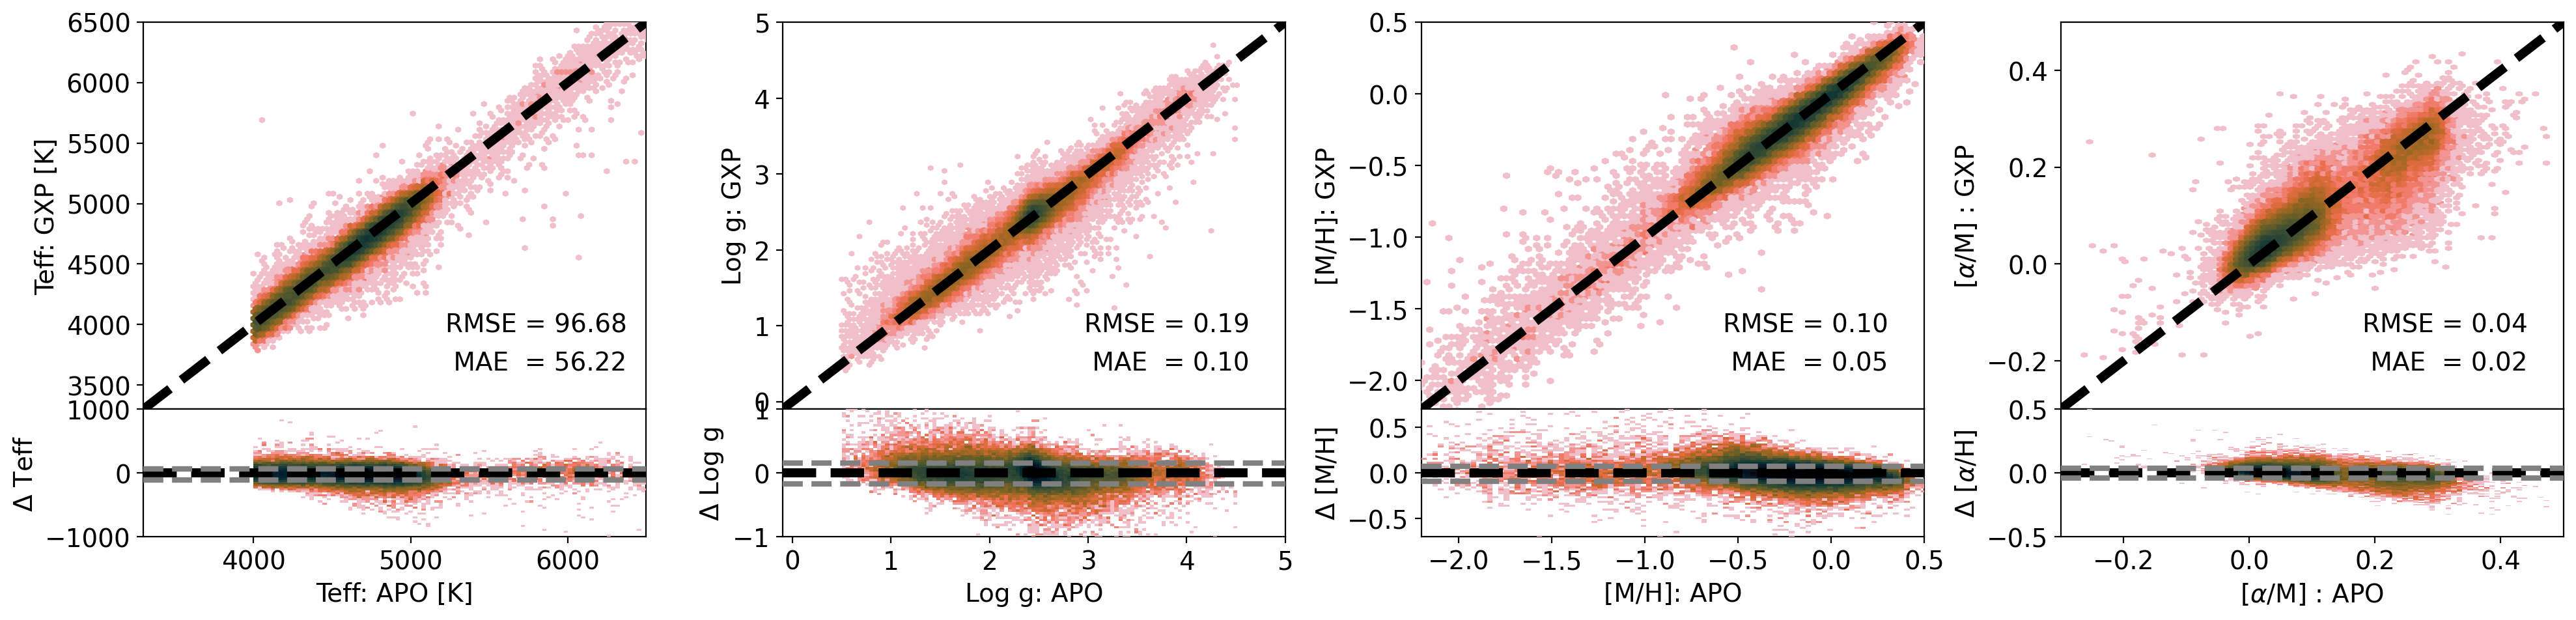

In [330]:
# df11 = pd.read_csv(data_dir+"APtransXP_1120.csv")
# print(df11.shape)
fig, axs = plt.subplots(1,4, figsize=(5*4, 5))

# pred_names = ['teff_B_ep500', 'logg_B_ep500', 'moh_B_ep500', 'aom_B_ep500']
pred_names = lb_result[0]
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']
# true_names = lb_result[0]
xranges = [[3300, 6500], [-0.1, 5], [-2.2, 0.5], [-0.3, 0.5]]
yranges = [[-1000, 1000],  [-1, 1],   [-0.7, 0.7], [-0.5, 0.5]]
xlabels = ['Teff: APO [K]', 'Log g: APO', '[M/H]: APO', r"[$\alpha$/M] : APO"]
ylabels = ['Teff: GXP [K]', 'Log g: GXP', '[M/H]: GXP', r"[$\alpha$/M] : GXP"]
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

for i in range(4):
    ax1, ax2 = draw_compare(
        axs[i], rdf[true_names[i]], rdf[pred_names[i]],
        xrange=xranges[i], 
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i])
    ax2.set_ylim(yranges[i])

plt.tight_layout()

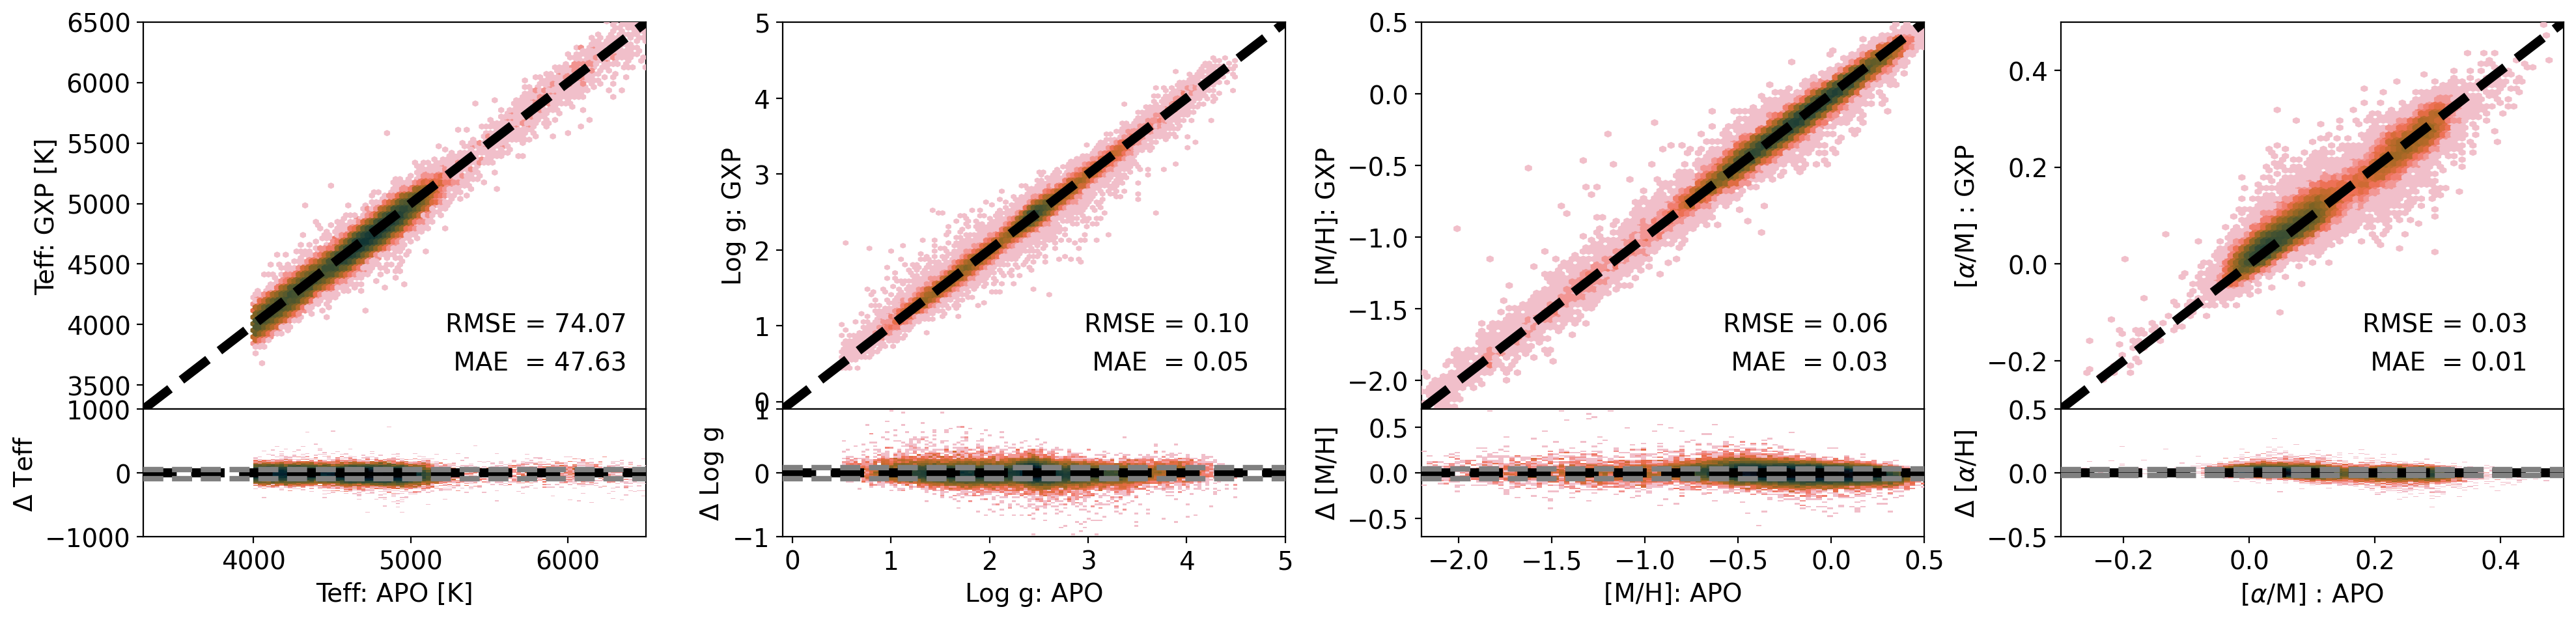

In [331]:
fig, axs = plt.subplots(1,4, figsize=(5*4, 5))

pred_names = lb_result[1]
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']
# true_names = lb_result[0]
xranges = [[3300, 6500], [-0.1, 5], [-2.2, 0.5], [-0.3, 0.5]]
yranges = [[-1000, 1000],  [-1, 1],   [-0.7, 0.7], [-0.5, 0.5]]
xlabels = ['Teff: APO [K]', 'Log g: APO', '[M/H]: APO', r"[$\alpha$/M] : APO"]
ylabels = ['Teff: GXP [K]', 'Log g: GXP', '[M/H]: GXP', r"[$\alpha$/M] : GXP"]
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

for i in range(4):
    ax1, ax2 = draw_compare(
        axs[i], rdf[true_names[i]], rdf[pred_names[i]],
        xrange=xranges[i]
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i])
    ax2.set_ylim(yranges[i])


plt.tight_layout()


In [181]:
# df_result['snr_bp'].plot(kind='hist')
# df_result['snr_rp'].plot(kind='hist')

snr_bp_grids = np.arange(0, 700+100, 100)
snr_rp_grids = np.arange(0, 2000+200, 200)


df_result = rdf.assign(
    snr_bp_bin=pd.cut(rdf['snr_bp'], bins=snr_bp_grids),
    snr_rp_bin=pd.cut(rdf['snr_rp'], bins=snr_rp_grids),
)


In [142]:
from astropy.stats import bootstrap

boot_stat = lambda x: (np.percentile(x, 14), np.percentile(x, 50), np.percentile(x, 86))

def rmse(res):
    return np.sqrt(np.mean(res**2))



In [151]:
pred_names = ['teff_trans', 'logg_trans', 'prlx_trans', 'moh_trans', 'aom_trans']
true_names = ['TEFF', 'LOGG', 'GAIAEDR3_PARALLAX', 'M_H', 'ALPHA_M']
e_true_names = ['TEFF_ERR', 'LOGG_ERR', 'GAIAEDR3_PARALLAX_ERROR', 'M_H_ERR', 'ALPHA_M_ERR']
n_pars = len(pred_names)
n_boots = 10

chi_arr_bp = np.zeros([n_boots, 3, len(snr_bp_grids)-1, len(pred_names)])
chi_arr_rp = np.zeros([n_boots, 3, len(snr_rp_grids)-1, len(pred_names)])
rmse_bp = np.zeros([n_boots, len(snr_bp_grids)-1, len(pred_names)])
rmse_rp = np.zeros([n_boots, len(snr_rp_grids)-1, len(pred_names)])

for i, (gn, group) in enumerate(df_result.groupby(['snr_bp_bin'])):
    print(len(group))
    
    for j in range(n_pars):
        group_boot = bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])/group[e_true_names[j]]),
                               n_boots, bootfunc=boot_stat)
        chi_arr_bp[:,:,i,j] = group_boot
        rmse_bp[:,i,j] =  bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])),
                               n_boots, bootfunc=rmse)
        
        
for i, (gn, group) in enumerate(df_result.groupby(['snr_rp_bin'])):
    print(len(group))
    
    for j in range(n_pars):
        group_boot = bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])/group[e_true_names[j]]),
                               n_boots, bootfunc=boot_stat)
        chi_arr_rp[:,:,i,j] = group_boot
        rmse_rp[:,i,j] =  bootstrap(np.array(group[pred_names[j]]-group[true_names[j]]),
                               n_boots, bootfunc=rmse)


2081
5285
11068
27571
24502
8048
2129
1330
5282
12081
18433
21432
15100
5375
1571
495
150


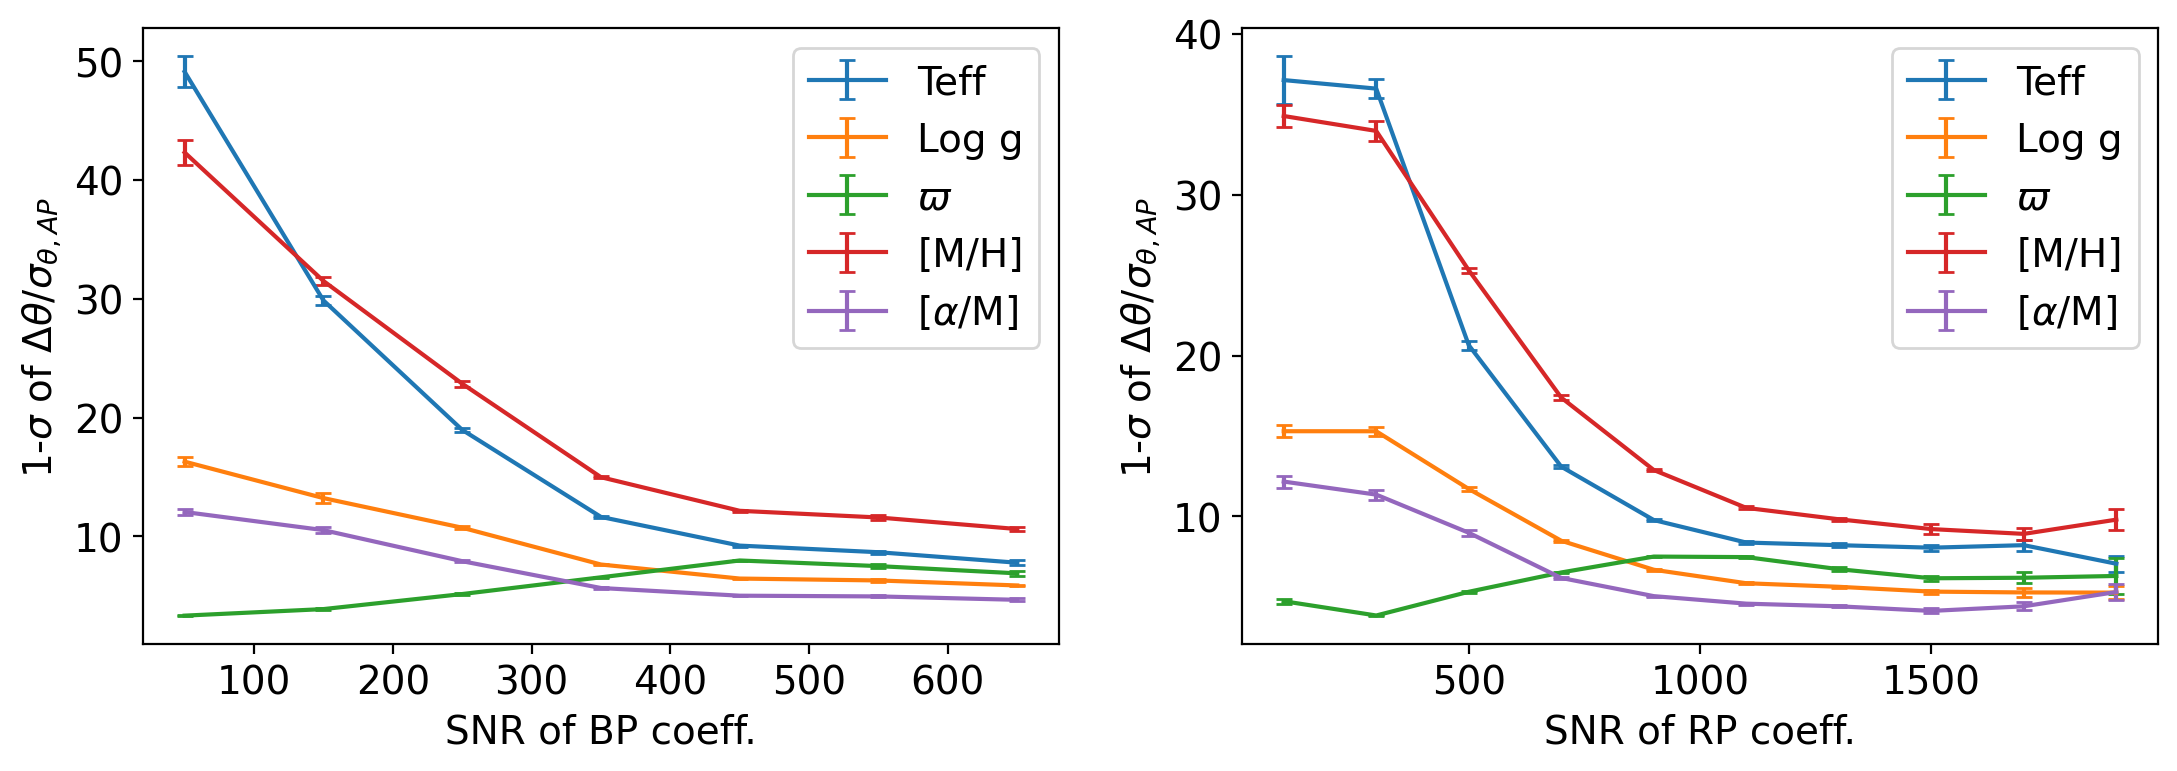

In [175]:
labels = ['Teff', 'Log g', r'$\varpi$', '[M/H]', r'[$\alpha$/M]']

snr_bp_mids = snr_bp_grids[:-1]+np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1]+np.diff(snr_rp_grids)*0.5


fig, axs = plt.subplots(1,2, figsize=(13,4))
ax1, ax2 = axs.ravel()

for i in range(len(labels)):
    if i<10:
        ax1.errorbar(
            snr_bp_mids, 
            # np.mean(rmse_bp[:,:,i], axis=0), 
            # np.std(rmse_bp[:,:,i], axis=0), label=labels[i]
            0.5*np.mean(chi_arr_bp[:,2,:,i]-chi_arr_bp[:,0,:,i], axis=0), 
             0.5*np.std(chi_arr_bp[:,2,:,i]-chi_arr_bp[:,0,:,i], axis=0), 
            label=labels[i], fmt='-', capsize=3
        )
        ax1.legend();
        ax1.set_xlabel("SNR of BP coeff.");
        ax1.set_ylabel(r"1-$\sigma$ of $\Delta \theta / \sigma_{\theta, AP}}$");
        
        ax2.errorbar(
            snr_rp_mids, 
            # np.mean(rmse_rp[:,:,i], axis=0), 
            # np.std(rmse_rp[:,:,i], axis=0), 
             0.5*np.mean(chi_arr_rp[:,2,:,i]-chi_arr_rp[:,0,:,i], axis=0), 
             0.5*np.std(chi_arr_rp[:,2,:,i]-chi_arr_rp[:,0,:,i], axis=0), 
            label=labels[i], fmt='-', capsize=3
        )
        ax2.legend();
        ax2.set_xlabel("SNR of RP coeff.");
        ax2.set_ylabel(r"1-$\sigma$ of $\Delta \theta / \sigma_{\theta, AP}$");

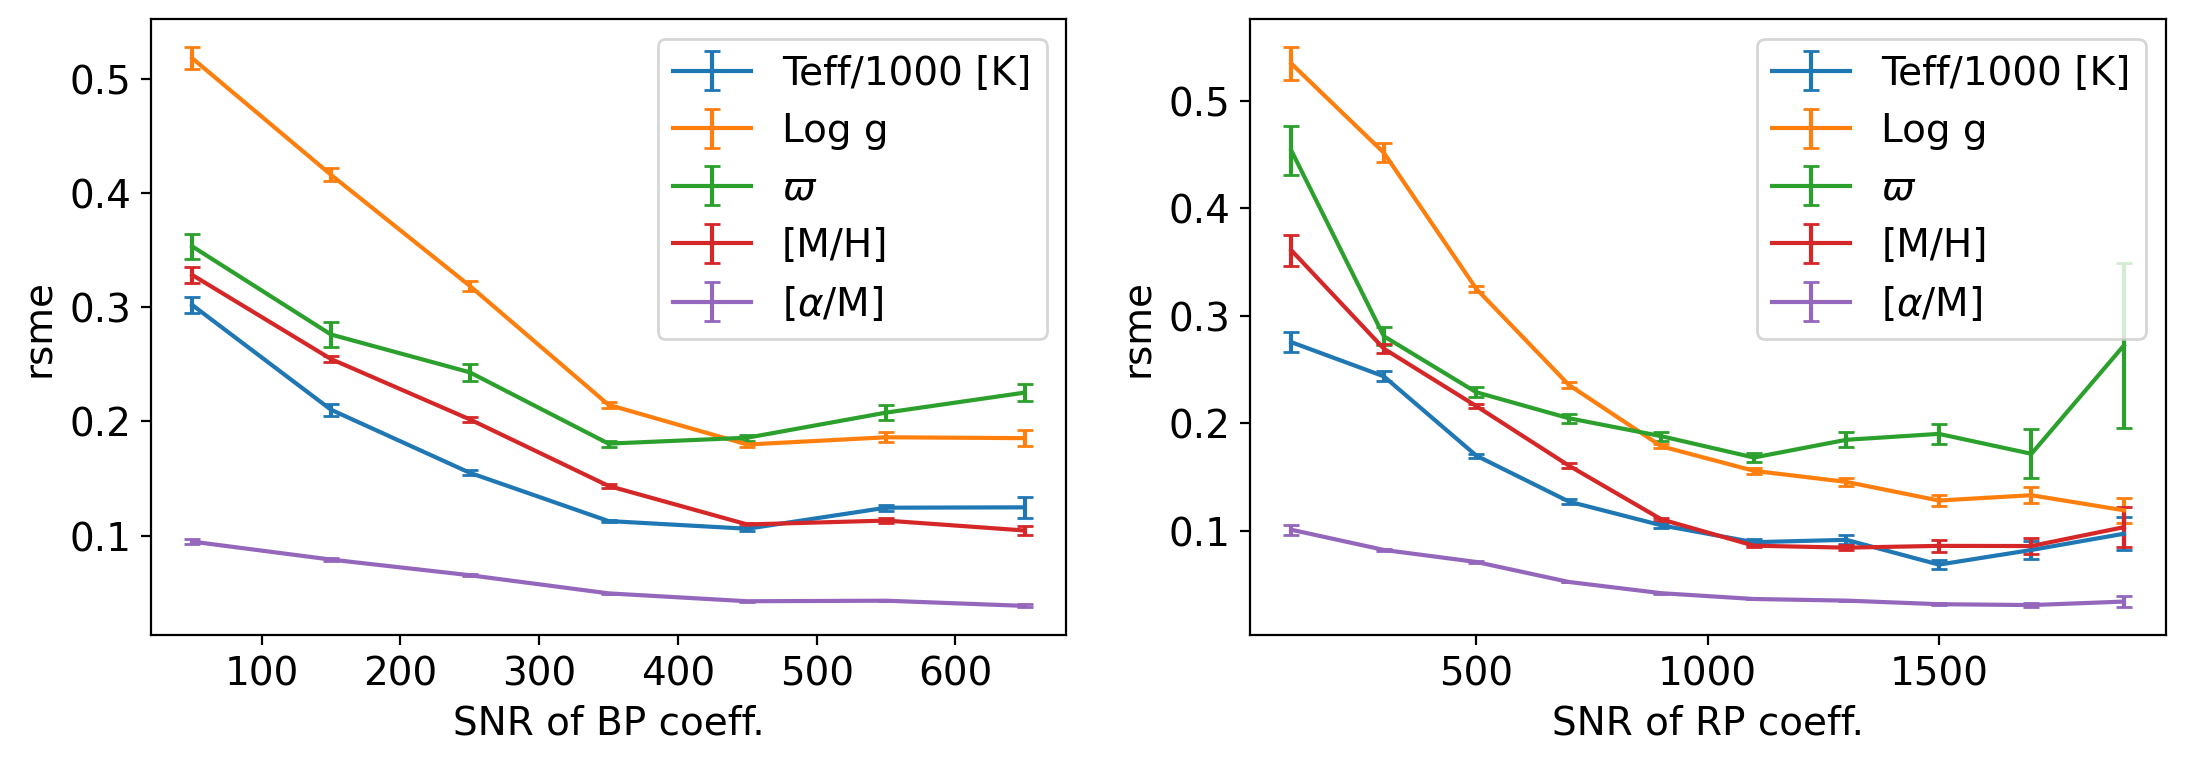

In [174]:
labels = ['Teff', 'Log g', r'$\varpi$', '[M/H]', r'[$\alpha$/M]']

snr_bp_mids = snr_bp_grids[:-1]+np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1]+np.diff(snr_rp_grids)*0.5


fig, axs = plt.subplots(1,2, figsize=(13,4))
ax1, ax2 = axs.ravel()

for i in range(len(labels)):
    if i==0:
        ax1.errorbar(
            snr_bp_mids, 
            1e-3*np.mean(rmse_bp[:,:,i], axis=0), 1e-3*np.std(rmse_bp[:,:,i], axis=0),
            label="Teff/1000 [K]", fmt='-', capsize=3
        )
        ax2.errorbar(
            snr_rp_mids, 
            1e-3*np.mean(rmse_rp[:,:,i], axis=0), 1e-3*np.std(rmse_rp[:,:,i], axis=0), 
            label="Teff/1000 [K]", fmt='-', capsize=3
    )
        
    elif i>0:
        ax1.errorbar(
            snr_bp_mids, 
            np.mean(rmse_bp[:,:,i], axis=0), np.std(rmse_bp[:,:,i], axis=0),
            label=labels[i], fmt='-', capsize=3
        )
        ax2.errorbar(
        snr_rp_mids, 
        np.mean(rmse_rp[:,:,i], axis=0), np.std(rmse_rp[:,:,i], axis=0), 
        label=labels[i], fmt='-', capsize=3
    )
        
    ax1.legend();
    ax1.set_xlabel("SNR of BP coeff.");
    ax1.set_ylabel(r"rsme");

    ax2.legend();
    ax2.set_xlabel("SNR of RP coeff.");
    ax2.set_ylabel(r"rsme")

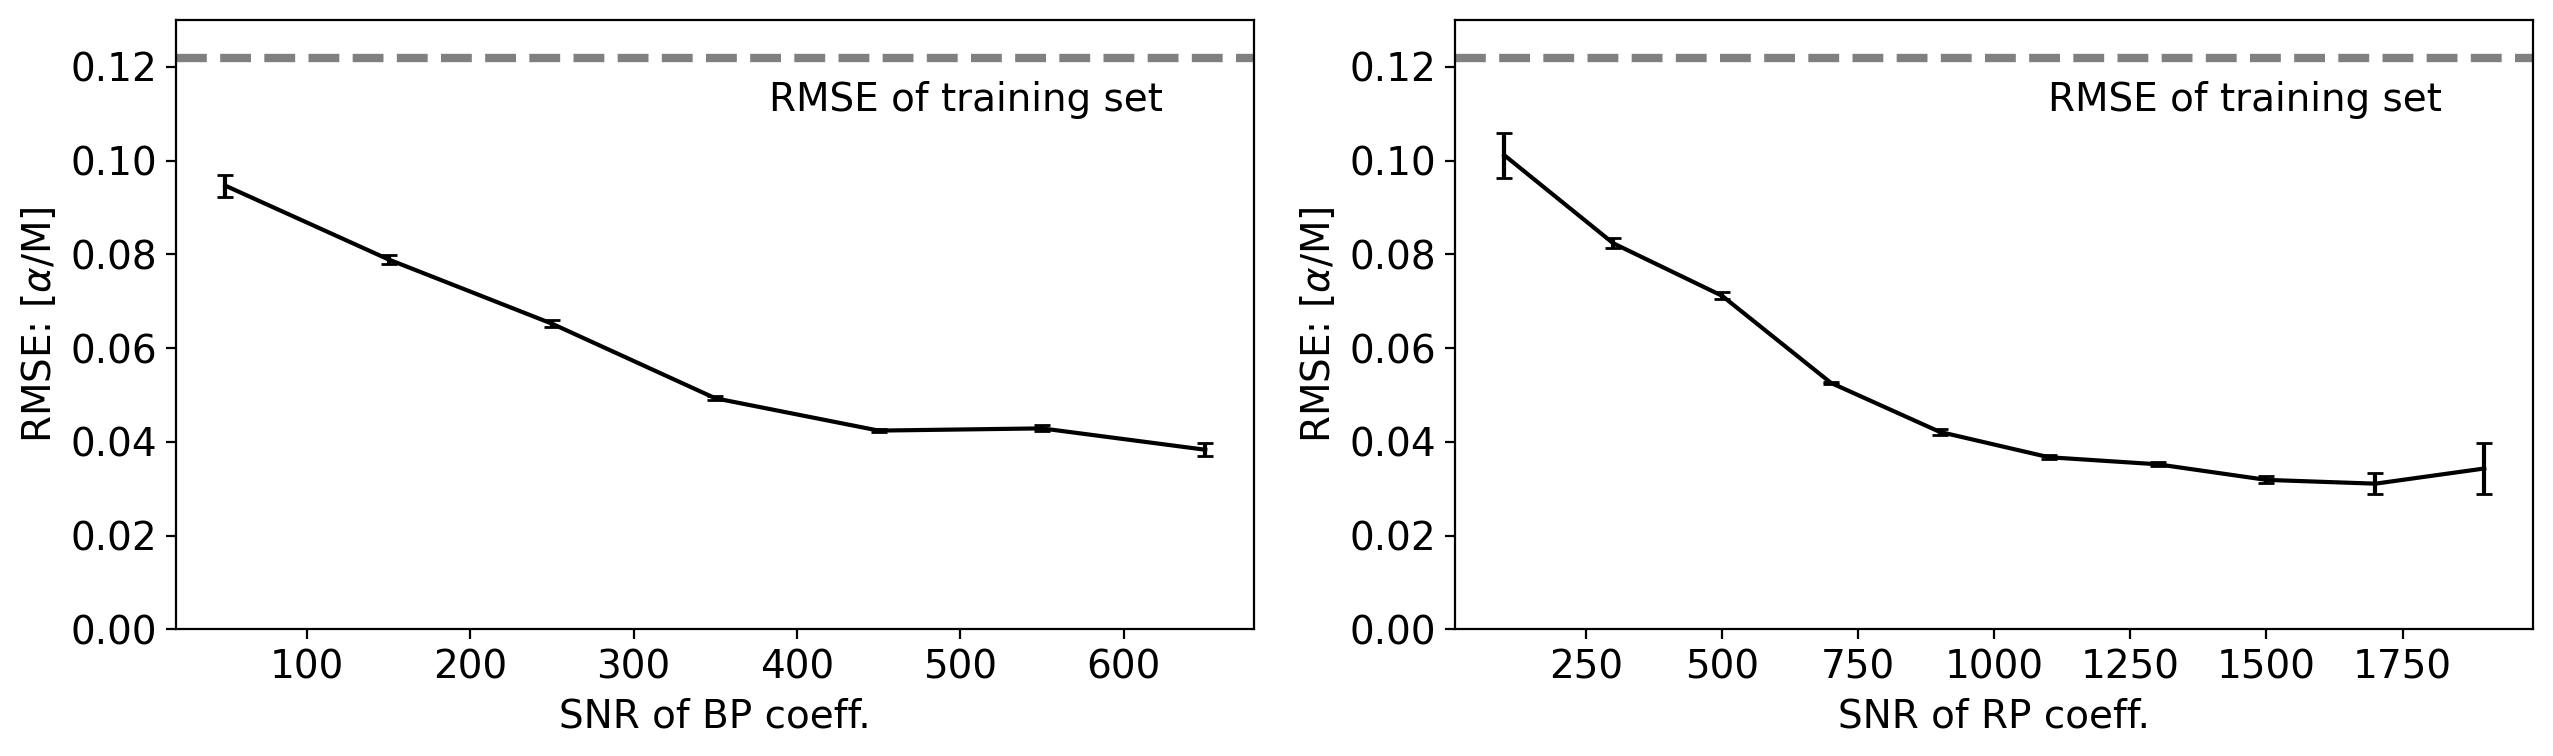

In [211]:
labels = [r'[$\alpha$/M]']

snr_bp_mids = snr_bp_grids[:-1]+np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1]+np.diff(snr_rp_grids)*0.5


fig, axs = plt.subplots(1,2, figsize=(13,4))
ax1, ax2 = axs.ravel()

i=0
ax1.errorbar(
    snr_bp_mids, 
    np.mean(rmse_bp[:,:,4], axis=0), np.std(rmse_bp[:,:,4], axis=0),
     fmt='-', capsize=3, c='k'
)
ax2.errorbar(
    snr_rp_mids, 
    np.mean(rmse_rp[:,:,4], axis=0), np.std(rmse_rp[:,:,4], axis=0), 
    fmt='-', capsize=3, c='k'
)
        

ax1.set_xlabel("SNR of BP coeff.");
ax1.set_ylabel(r"RMSE: [$\alpha$/M]");

ax1.axhline(y=rmse(df_result['aom_trans']), lw=3, ls='--', color='grey',
            label="RMSE of traing set")
ax2.axhline(y=rmse(df_result['aom_trans']), lw=3, ls='--', color='grey',
            label="RMSE of traing set")

ax2.set_ylabel(r"RMSE: [$\alpha$/M]");
ax2.set_xlabel("SNR of RP coeff.");

ax1.text(0.55, 0.85, 'RMSE of training set', transform=ax1.transAxes)
ax2.text(0.55, 0.85, 'RMSE of training set', transform=ax2.transAxes)


ax1.set_ylim([0, 0.13]);
ax2.set_ylim([0, 0.13]);
plt.tight_layout()
fig.savefig("../fig/rsme_alpha.png")

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(5*5, 5*1))

pred_names = ['teff_trans', 'logg_trans', 'prlx_trans', 'moh_trans', 'aom_trans']
true_names = ['TEFF', 'LOGG', 'GAIAEDR3_PARALLAX', 'M_H', 'ALPHA_M']
xranges = [[3300, 6500], [-0.1, 5], [-0.1, 2.], [-2.2, 0.5], [-0.3, 0.5]]
yranges = [[-800, 800],  [-1.2, 1.2], [-1., 1.], [-0.6, 0.6], [-0.2, 0.2]]
xlabels = ['Teff: APO [K]', 'Log g: APO', r'$\varpi$: APO [mas]', 
           '[M/H]: APO', r"[$\alpha$/M] : APO"]
ylabels = ['Teff: GXP [K]', 'Log g: GXP', r'$\varpi$: GXP [mas]', 
           '[M/H]: GXP', r"[$\alpha$/M] : GXP"]
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta \varpi$',
            r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/M]']

for i in range(len(axs)):
    ax1, ax2 = draw_compare(
        axs[i], df_result[pred_names[i]], df_result[true_names[i]],
        xrange=xranges[i], bins=100
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i])


plt.tight_layout()

In [ ]:
group = df_result[df_result['GAIAEDR3_PHOT_G_MEAN_MAG']<12.]
print(group.shape)


fig, axs = plt.subplots(1,5, figsize=(5*5, 5*1))

for i in range(len(axs)):
    ax1, ax2 = draw_compare(
        axs[i], group[pred_names[i]], group[true_names[i]],
        xrange=xranges[i], bins=100
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    # ax1.set_title("Gmag < 12 mag")
    
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i])

plt.tight_layout()

In [252]:
# fig.savefig("../fig/compare4d.pdf")

In [ ]:
group = df_result[df_result['GAIAEDR3_PHOT_G_MEAN_MAG']>12.]
print(group.shape)


fig, axs = plt.subplots(1,5, figsize=(5*5, 5*1))

for i in range(len(axs)):
    ax1, ax2 = draw_compare(
        axs[i], group[pred_names[i]], group[true_names[i]],
        xrange=xranges[i]
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax1.set_title("Gmag > 12 mag")
    
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i])


plt.tight_layout()

In [243]:
def draw_moh_aom(ax, moh, aom, bins=100):
    
    _, _, _, img = ax.hist2d(
        moh, aom,
        bins=bins, norm=LogNorm(), 
        cmap=cmap
    )
    clb1 = fig.colorbar(img, ax=ax,);
    clb1.set_label('Counts', labelpad=-20, y=1.1, rotation=0)

    ax.set_xlabel("[M/H] : GXP");
    ax.set_ylabel(r"[$\alpha$/M] : GXP");
    ax.set_xlim([-2.5, 0.5]);
    ax.set_ylim([-0.3, 0.5]);
    return ax


def plot_kiel(ax, teff, logg, moh, bins=100):
    
    teff_bins = np.linspace(3300, 6500, 50)
    logg_bins = np.linspace(0, 5, 50)

    img = ax.scatter(teff, logg, cmap='coolwarm', s=3, c=moh, vmin=-1, vmax=0, alpha=0.5)
    
    ax.set_xlim([6500, 3300]);
    ax.set_ylim([5, -0.2]);

    clb = fig.colorbar(img, ax=ax, extend='both');
    clb.set_label(r'[M/H]$_{\rm GXP}$', labelpad=-20, y=1.1, rotation=0, )
    ax.set_xlabel("Teff : GXP");
    ax.set_ylabel("Log g: GXP");
    return ax

In [254]:
BIN = 5

df_result = df_result.assign(
    G_bin = pd.cut(df_result['GAIAEDR3_PHOT_G_MEAN_MAG'], bins=BIN),
    B_bin = pd.cut(df_result['GAIAEDR3_PHOT_BP_MEAN_MAG'], bins=BIN),
    R_bin = pd.cut(df_result['GAIAEDR3_PHOT_RP_MEAN_MAG'], bins=BIN),
)


In [ ]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

fig, axs = plt.subplots(3, BIN, figsize=(5*BIN, 4*3))


for i, (gname, group) in enumerate(df_result.groupby('G_bin')):
    ax1 = draw_moh_aom(
        axs[0,i], group['moh_trans'], group['aom_trans'],
    )
    
    
    ax2 = plot_kiel(
        axs[1,i], group['teff_trans'], group['logg_trans'],
        group['moh_trans'],
    )
    in_ax = inset_axes(ax2, width="30%", height=1., loc=2)
    in_ax.hist(group['GAIAEDR3_PHOT_G_MEAN_MAG'], bins=10, alpha=0.6, color='grey')
    in_ax.set_xlim([8, 16]);
    in_ax.set_yticks([]);
    in_ax.xaxis.set_tick_params(labelsize=10)
    # in_ax.set_xticks([8, 12, 16], fontize=8);
    in_ax.set_xlabel('Gmag', fontsize=10);
    plt.tick_params(top='off', bottom='off', left='off', right='off', 
                    labelleft='off', labelbottom='on')
    
    
    ax3 =  plot_kiel(
        axs[2,i], group['TEFF'], group['LOGG'],
        group['M_H'],
    )

plt.tight_layout()

In [202]:
BIN = 10

df_result = df_result.assign(
    G_bin = pd.cut(df_result['GAIAEDR3_PHOT_G_MEAN_MAG'], bins=BIN),
    B_bin = pd.cut(df_result['GAIAEDR3_PHOT_BP_MEAN_MAG'], bins=BIN),
    R_bin = pd.cut(df_result['GAIAEDR3_PHOT_RP_MEAN_MAG'], bins=BIN),
)

df_result = df_result.assign(
    Delta_teff = df_result['teff_trans']-df_result['TEFF'], 
    Delta_logg =  df_result['logg_trans']-df_result['LOGG'], 
    Delta_moh =  df_result['moh_trans']-df_result['M_H'], 
    Delta_aom =  df_result['aom_trans']-df_result['ALPHA_M'], 
)


# rmse_teff_Gbin = df_result.groupby('G_bin').apply(lambda x: mean_squared_error(x.teff_trans, x.TEFF, squared=False))


# ALPHA abundance trustworthy


In [332]:

print(rmse(rdf['ALPHA_M']-rdf['aom_cross_ep300']))
print(mae(rdf['ALPHA_M']-rdf['aom_cross_ep300']))
print(np.std(rdf['ALPHA_M']-rdf['aom_cross_ep300']))


0.04403334955280934
0.022137193603515626
0.044027099885752395


In [355]:
labels = [r'[$\alpha$/M]']

snr_bp_grids = np.arange(100, 1000+200, 100)
snr_rp_grids = np.arange(100, 2000+200, 200)
low_snr_grids = np.linspace(1, 5, 11)
# low_snr_grids = np.array([1, 2, 3, 5, 10])


rdf = rdf.assign(
    snr_bp_bin  = pd.cut(rdf['snr_bp'],   bins=snr_bp_grids),
    snr_bp10_bin= pd.cut(rdf['snr_bp10'], bins=snr_bp_grids),
    snr_bp55_bin= pd.cut(rdf['snr_bp55'], bins=low_snr_grids),
    snr_rp_bin  = pd.cut(rdf['snr_rp'],   bins=snr_rp_grids),
    snr_rp10_bin= pd.cut(rdf['snr_rp10'], bins=snr_rp_grids),
    snr_rp55_bin= pd.cut(rdf['snr_rp55'], bins=low_snr_grids),
)

snr_bp_mids = snr_bp_grids[:-1] + np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1] + np.diff(snr_rp_grids)*0.5
low_snr_mids= low_snr_grids[:-1]+ np.diff(low_snr_grids)*0.5

pred_names = "aom_cross_ep300"
true_names = "ALPHA_M"
n_boots = 10

# rmse_bp = np.zeros([n_boots, len(snr_bp_grids)-1])
# rmse_rp = np.zeros([n_boots, len(snr_rp_grids)-1])
rmse_arr = np.zeros([6, n_boots, len(snr_bp_mids)])


bin_names = ["snr_bp_bin", "snr_bp10_bin", "snr_bp55_bin", 
            "snr_rp_bin", "snr_rp10_bin", "snr_rp55_bin"]


for j, bin_name in enumerate(bin_names):
    print("bin %s stats."%bin_name)
    
    for i, (gn, group) in enumerate(rdf.groupby([bin_name])):
        print(len(group))
        rmse_arr[j,:,i] =  bootstrap(np.array((group[pred_names]-group[true_names])), n_boots, bootfunc=rmse)
        
    

bin snr_bp_bin stats.
1925
6831
23773
23338
7856
2096
491
110
16
3
bin snr_bp10_bin stats.
840
1871
4418
12379
19015
15920
7392
3035
1181
424
bin snr_bp55_bin stats.
9755
20827
18022
9905
4572
2043
881
385
151
62
bin snr_rp_bin stats.
482
4290
11780
18009
18859
9264
2763
865
255
89
bin snr_rp10_bin stats.
40
289
1536
3693
6217
8618
10354
11463
10548
7028
bin snr_rp55_bin stats.
16757
16845
10833
7210
4919
3337
2348
1525
1056
666


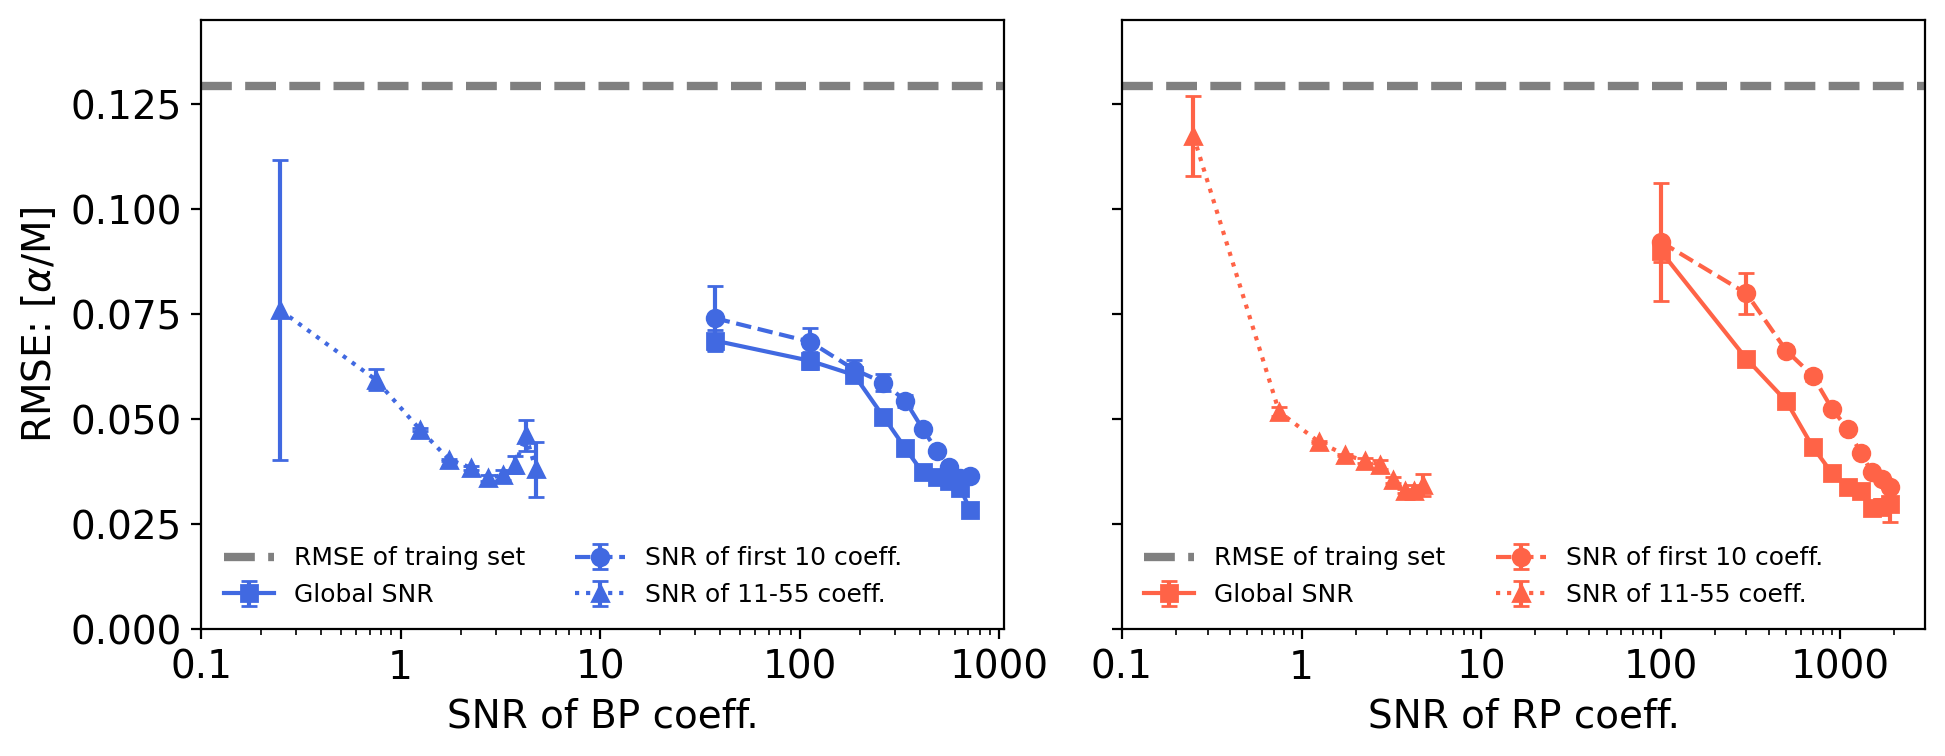

In [191]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1, ax2 = axs.ravel()


ax1.errorbar(
    snr_bp_mids, 
    np.mean(rmse_arr[0,:,:], axis=0), np.std(rmse_arr[0,:,:], axis=0),
     fmt='s-', capsize=3, c='royalblue', label='Global SNR'
)
ax1.errorbar(
    snr_bp_mids, 
    np.mean(rmse_arr[1,:,:], axis=0), np.std(rmse_arr[1,:,:], axis=0),
     fmt='o--', capsize=3, c='royalblue', label='SNR of first 10 coeff.'
)
ax1.errorbar(
    low_snr_mids, 
    np.mean(rmse_arr[2,:,:], axis=0), np.std(rmse_arr[2,:,:], axis=0),
     fmt='^:', capsize=3, c='royalblue', label='SNR of 11-55 coeff.'
)
ax1.set_xscale('log')

ax1.set_xlabel("SNR of BP coeff.");
ax1.set_ylabel(r"RMSE: [$\alpha$/M]");
ax1.axhline(y=rmse(rdf['ALPHA_M']), lw=3, ls='--', color='grey',
            label="RMSE of traing set")
ax2.axhline(y=rmse(rdf['ALPHA_M']), lw=3, ls='--', color='grey',
            label="RMSE of traing set")

ax2.errorbar(
    snr_rp_mids, 
    np.mean(rmse_arr[3,:,:], axis=0), np.std(rmse_arr[3,:,:], axis=0),
     fmt='s-', capsize=3, c='tomato', label='Global SNR'
)
ax2.errorbar(
    snr_rp_mids, 
    np.mean(rmse_arr[4,:,:], axis=0), np.std(rmse_arr[4,:,:], axis=0),
     fmt='o--', capsize=3, c='tomato', label='SNR of first 10 coeff.'
)
ax2.errorbar(
    low_snr_mids, 
    np.mean(rmse_arr[5,:,:], axis=0), np.std(rmse_arr[5,:,:], axis=0),
     fmt='^:', capsize=3, c='tomato', label='SNR of 11-55 coeff.'
)
ax2.set_xlabel("SNR of RP coeff.");
ax2.set_xscale('log')

# ax1.text(0.5, 0.85, 'RMSE of training set', transform=ax1.transAxes)
# ax2.text(0.5, 0.85, 'RMSE of training set', transform=ax2.transAxes)

ax1.set_ylim([0, 0.145]);
ax2.set_ylim([0, 0.145]);


ax1.set_xticks([0.1, 1, 10, 100, 1000]);
ax1.set_xticks([0.1, 1, 10, 100, 1000]);
ax1.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax1.set_xticklabels([0.1, 1, 10, 100, 1000]);

ax2.set_xticks([0.1, 1, 10, 100, 1000]);
ax2.set_xticks([0.1, 1, 10, 100, 1000]);
ax2.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax2.set_xticklabels([0.1, 1, 10, 100, 1000]);

ax1.legend(loc=3, fontsize=9, frameon=False, ncol=2);
ax2.legend(loc=3, fontsize=9, frameon=False, ncol=2);

plt.tight_layout()
# fig.savefig("../fig/rsme_alpha.png")

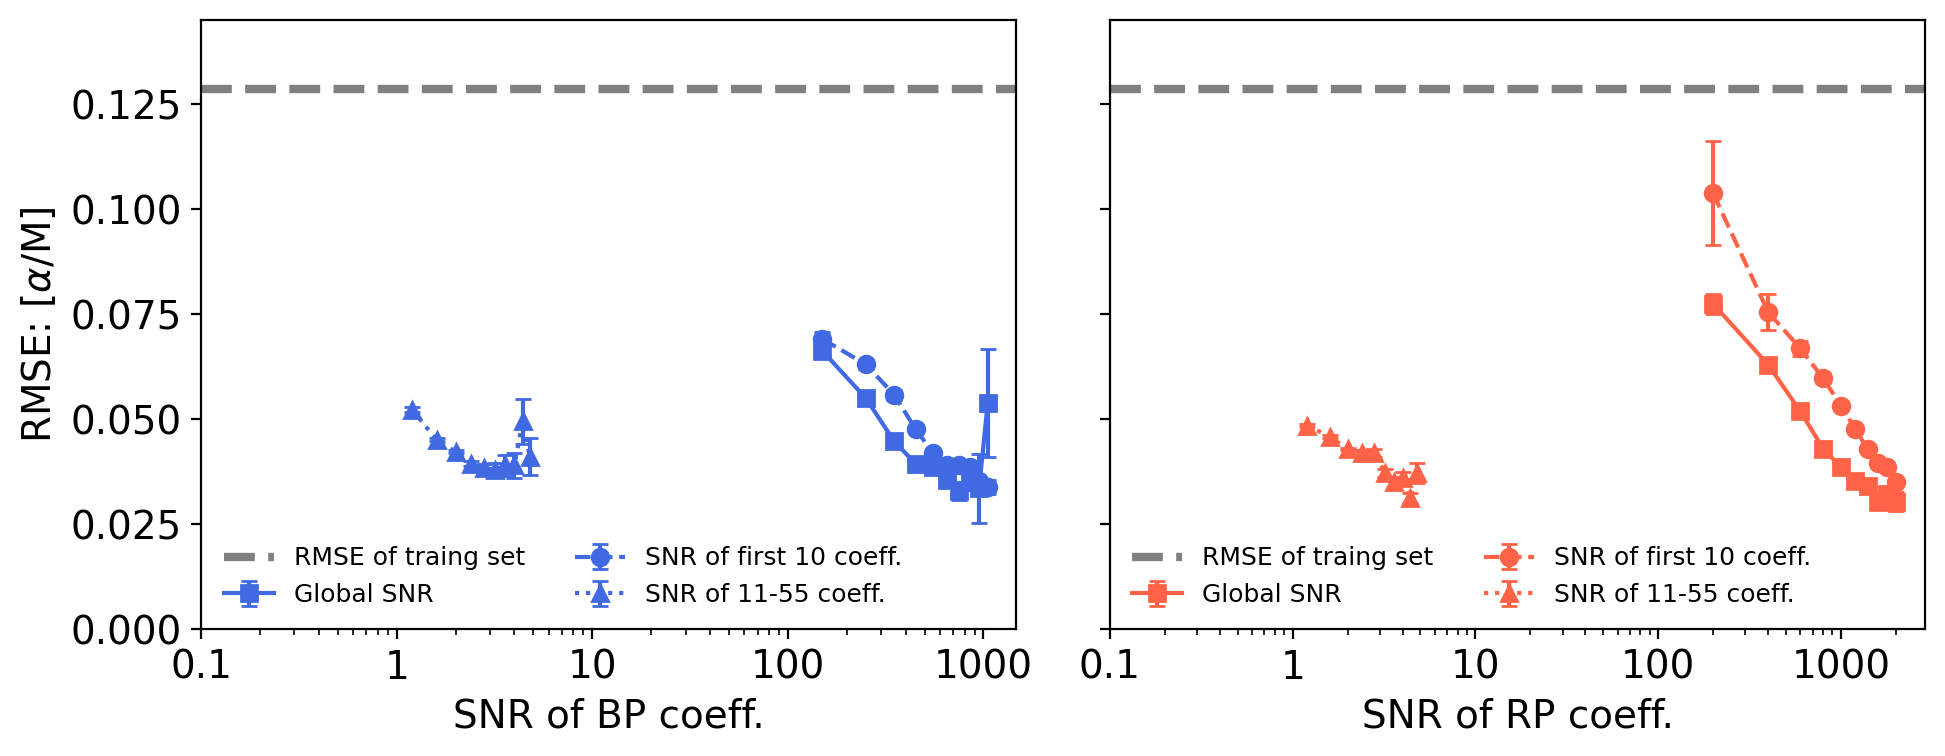

In [356]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1, ax2 = axs.ravel()


ax1.errorbar(
    snr_bp_mids, 
    np.mean(rmse_arr[0,:,:], axis=0), np.std(rmse_arr[0,:,:], axis=0),
     fmt='s-', capsize=3, c='royalblue', label='Global SNR'
)
ax1.errorbar(
    snr_bp_mids, 
    np.mean(rmse_arr[1,:,:], axis=0), np.std(rmse_arr[1,:,:], axis=0),
     fmt='o--', capsize=3, c='royalblue', label='SNR of first 10 coeff.'
)
ax1.errorbar(
    low_snr_mids, 
    np.mean(rmse_arr[2,:,:], axis=0), np.std(rmse_arr[2,:,:], axis=0),
     fmt='^:', capsize=3, c='royalblue', label='SNR of 11-55 coeff.'
)
ax1.set_xscale('log')

ax1.set_xlabel("SNR of BP coeff.");
ax1.set_ylabel(r"RMSE: [$\alpha$/M]");
ax1.axhline(y=rmse(rdf['ALPHA_M']), lw=3, ls='--', color='grey',
            label="RMSE of traing set")
ax2.axhline(y=rmse(rdf['ALPHA_M']), lw=3, ls='--', color='grey',
            label="RMSE of traing set")

ax2.errorbar(
    snr_rp_mids, 
    np.mean(rmse_arr[3,:,:], axis=0), np.std(rmse_arr[3,:,:], axis=0),
     fmt='s-', capsize=3, c='tomato', label='Global SNR'
)
ax2.errorbar(
    snr_rp_mids, 
    np.mean(rmse_arr[4,:,:], axis=0), np.std(rmse_arr[4,:,:], axis=0),
     fmt='o--', capsize=3, c='tomato', label='SNR of first 10 coeff.'
)
ax2.errorbar(
    low_snr_mids, 
    np.mean(rmse_arr[5,:,:], axis=0), np.std(rmse_arr[5,:,:], axis=0),
     fmt='^:', capsize=3, c='tomato', label='SNR of 11-55 coeff.'
)
ax2.set_xlabel("SNR of RP coeff.");
ax2.set_xscale('log')

# ax1.text(0.5, 0.85, 'RMSE of training set', transform=ax1.transAxes)
# ax2.text(0.5, 0.85, 'RMSE of training set', transform=ax2.transAxes)
ax1.set_ylim([0, 0.145]);
ax2.set_ylim([0, 0.145]);


ax1.set_xticks([0.1, 1, 10, 100, 1000]);
ax1.set_xticks([0.1, 1, 10, 100, 1000]);
ax1.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax1.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax2.set_xticks([0.1, 1, 10, 100, 1000]);
ax2.set_xticks([0.1, 1, 10, 100, 1000]);
ax2.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax2.set_xticklabels([0.1, 1, 10, 100, 1000]);

ax1.legend(loc=3, fontsize=9, frameon=False, ncol=2);
ax2.legend(loc=3, fontsize=9, frameon=False, ncol=2);

plt.tight_layout()

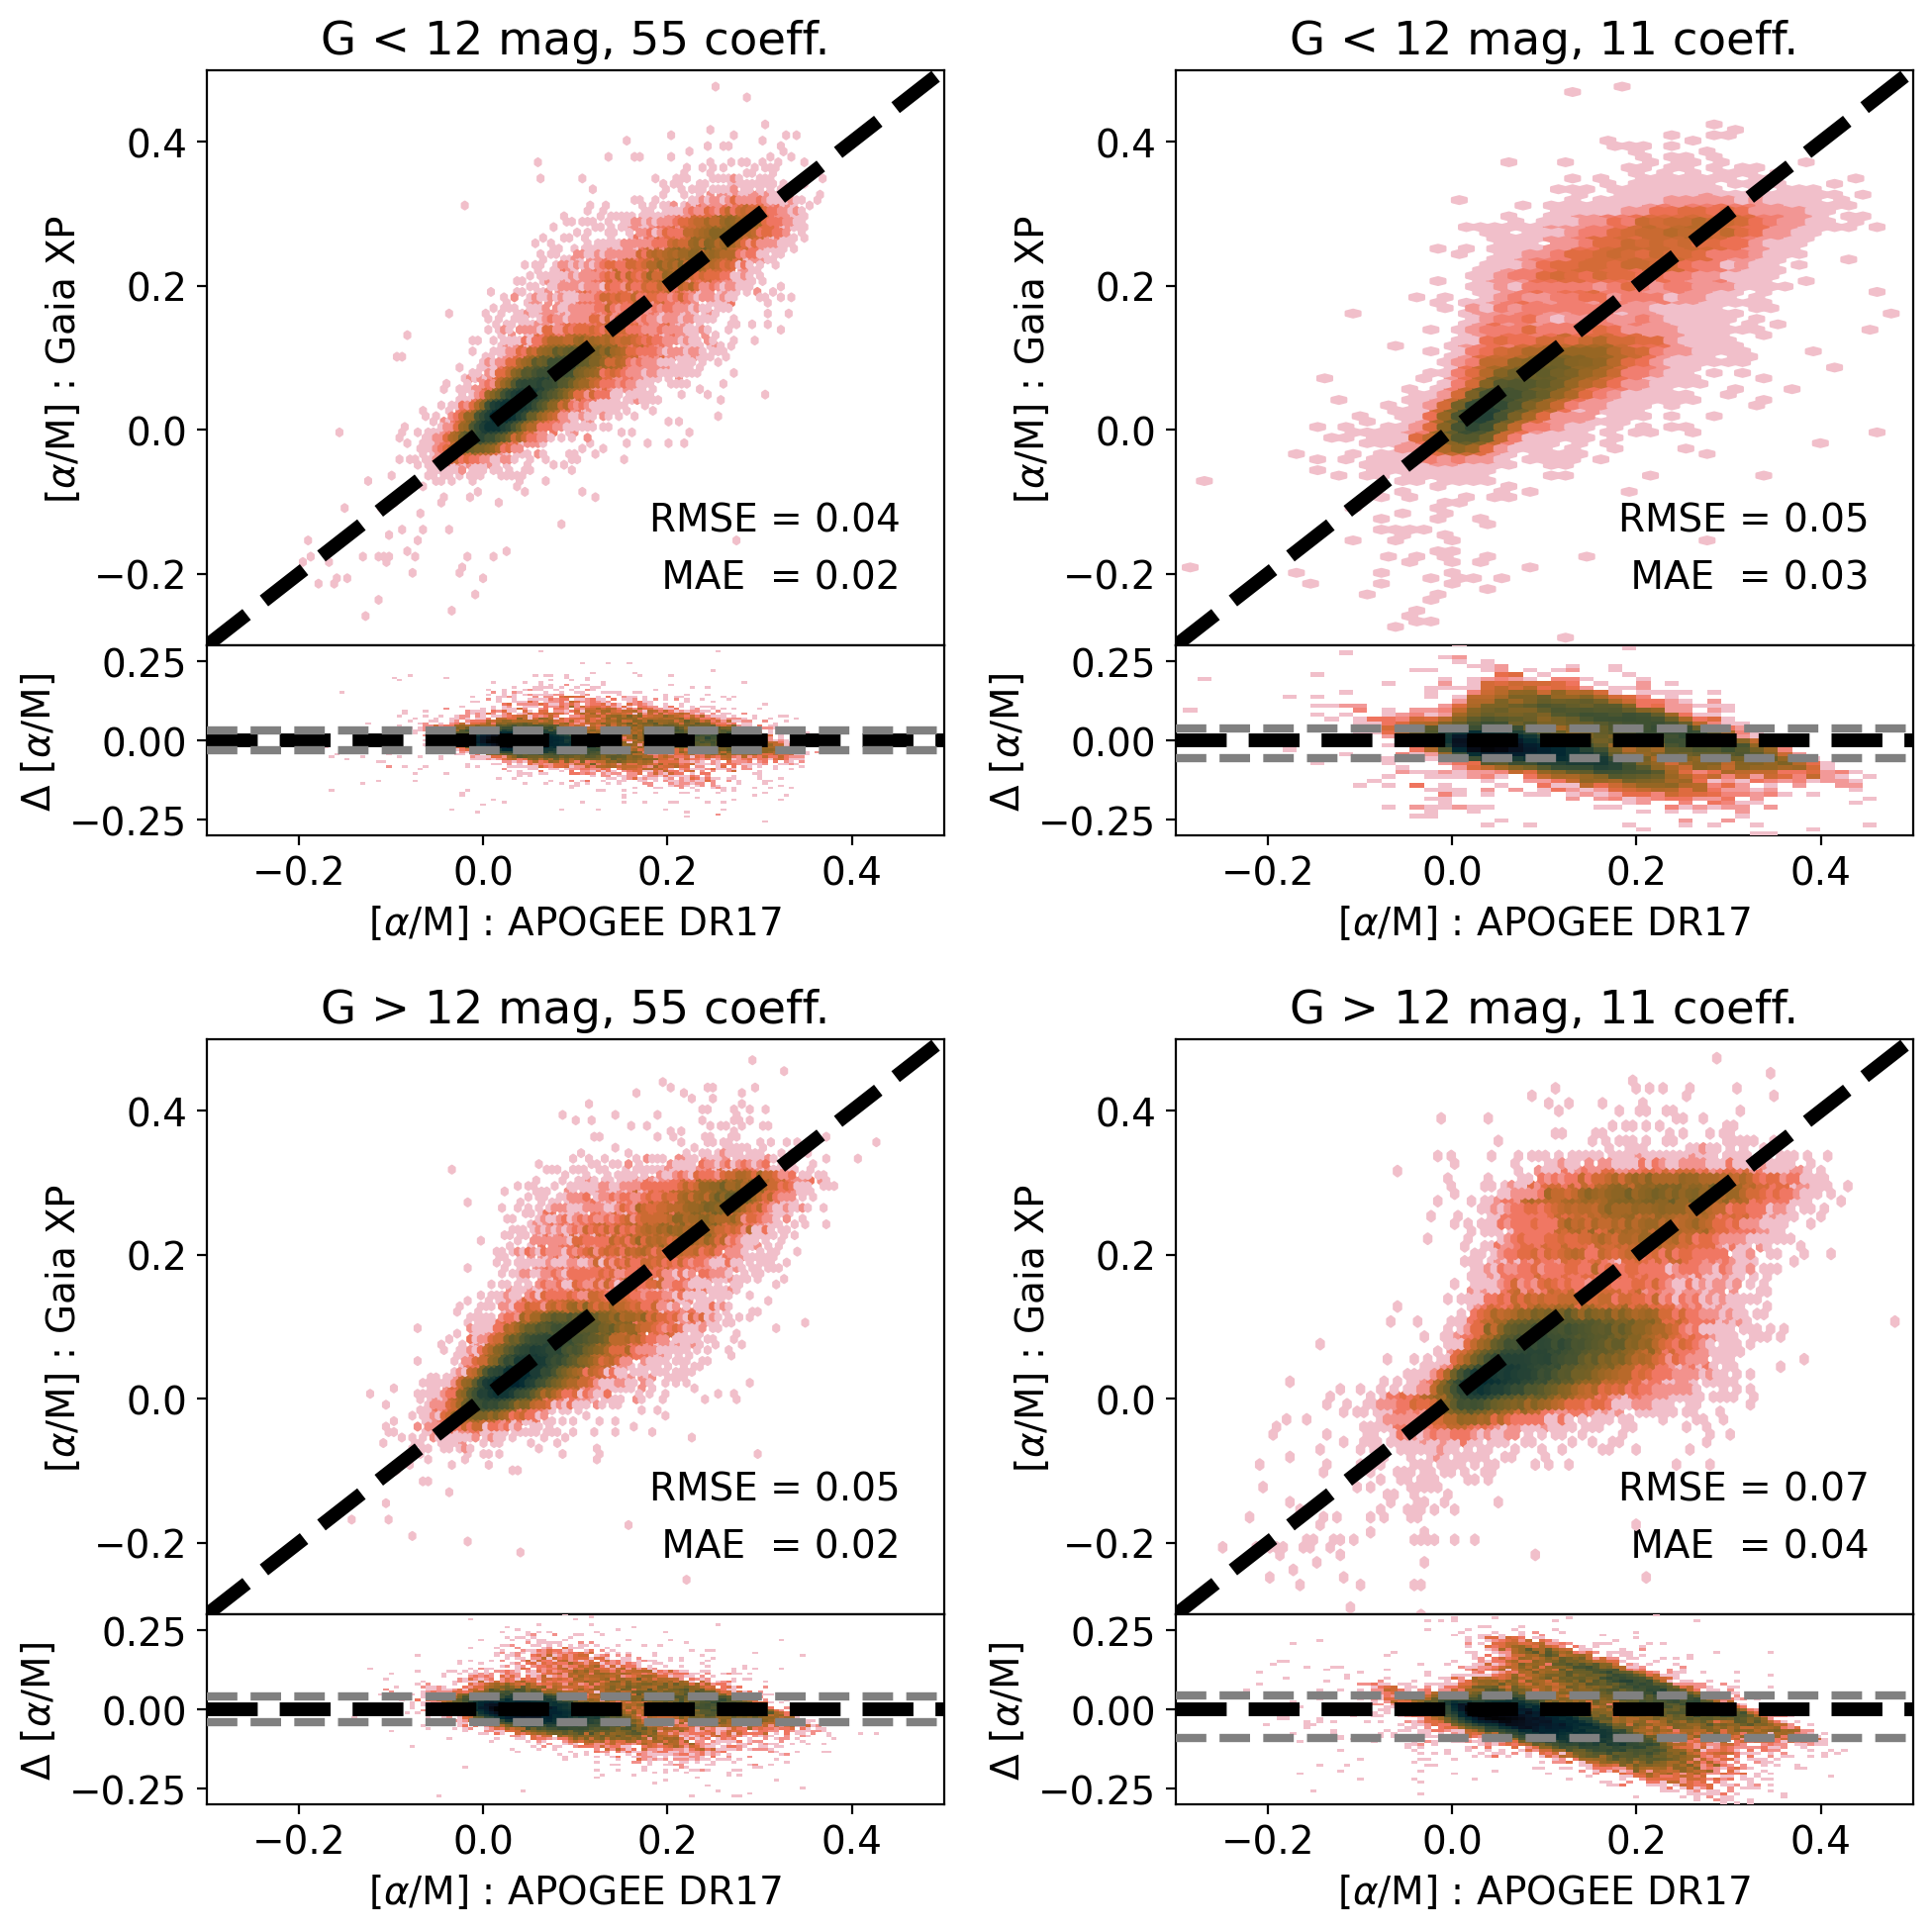

In [195]:
df11 = pd.read_csv(data_dir+"APtransXP_1120.csv")
# print(df11.shape)

fig, axs = plt.subplots(2,2, figsize=(5*2, 5*2))
titles = ['G < 12 mag, 55 coeff.', 'G < 12 mag, 11 coeff.', 
          'G > 12 mag, 55 coeff.', 'G > 12 mag, 11 coeff.', ]

for i in range(len(axs.ravel())):
    
    if i==0:
        ind = rdf['GAIAEDR3_PHOT_G_MEAN_MAG']<12
        ax1, ax2 = draw_compare(
            axs.ravel()[i], rdf['ALPHA_M'][ind], rdf[pred_names][ind],
            xrange=(-0.3,0.5)
        )
        
    elif i==1:
        ind = df11['GAIAEDR3_PHOT_G_MEAN_MAG']<12
        ax1, ax2 = draw_compare(
            axs.ravel()[i], df11['ALPHA_M'][ind], df11['aom_trans'][ind],
            xrange=(-0.3,0.5)
        )
    elif i==2:
        ind = rdf['GAIAEDR3_PHOT_G_MEAN_MAG']>12
        ax1, ax2 = draw_compare(
            axs.ravel()[i], rdf['ALPHA_M'][ind], rdf[pred_names][ind],
            xrange=(-0.3,0.5)
        )
    elif i==3:
        
        ind = df11['GAIAEDR3_PHOT_G_MEAN_MAG']>12
        ax1, ax2 = draw_compare(
            axs.ravel()[i], df11['ALPHA_M'][ind], df11['aom_trans'][ind],
            xrange=(-0.3,0.5)
        )
        
    ax1.set_ylabel(r"[$\alpha$/M] : Gaia XP");
    ax1.set_xticks([]);
    ax1.set_title(titles[i])
    
    ax2.set_xlabel(r"[$\alpha$/M] : APOGEE DR17");
    ax2.set_ylabel(r"$\Delta$ [$\alpha$/M]");
    ax2.set_ylim([-0.3, 0.3])

plt.tight_layout()

# fig.savefig("../fig/aom_2x2.png")

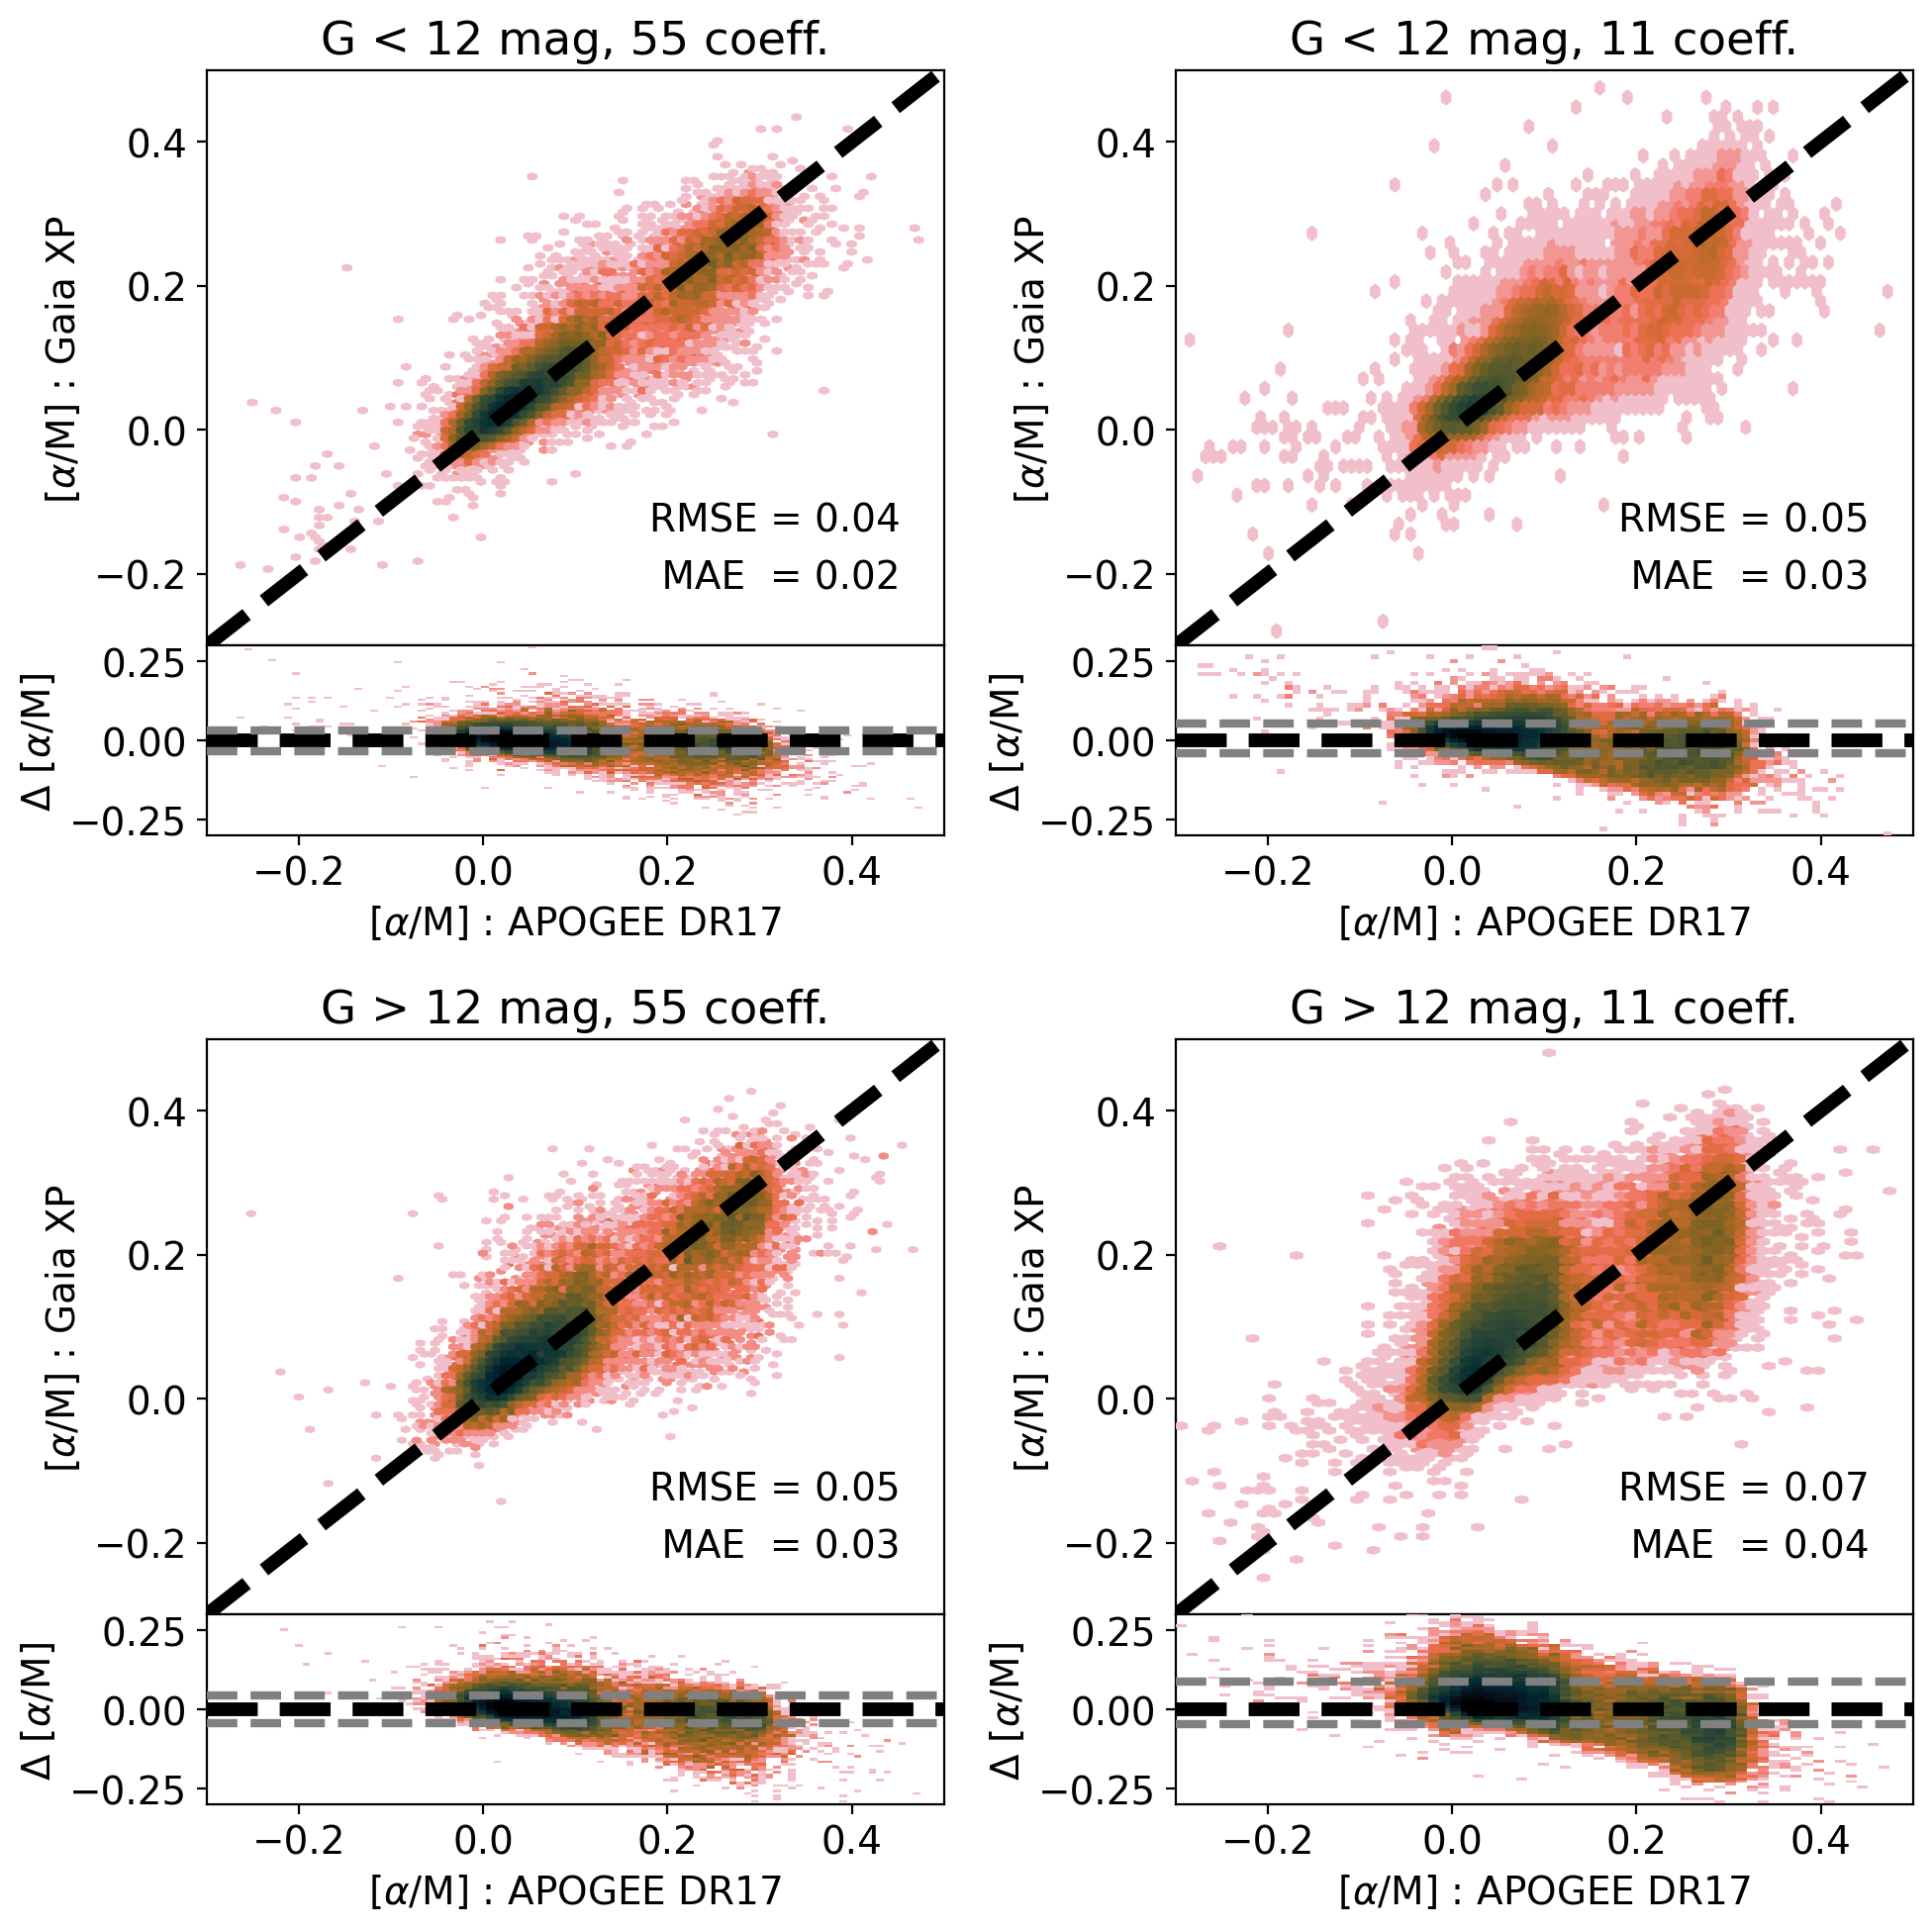

In [357]:
df11 = pd.read_csv(data_dir+"APtransXP_1120.csv")
# print(df11.shape)

fig, axs = plt.subplots(2,2, figsize=(5*2, 5*2))
titles = ['G < 12 mag, 55 coeff.', 'G < 12 mag, 11 coeff.', 
          'G > 12 mag, 55 coeff.', 'G > 12 mag, 11 coeff.', ]

for i in range(len(axs.ravel())):
    
    if i==0:
        ind = rdf['GAIAEDR3_PHOT_G_MEAN_MAG']<12
        ax1, ax2 = draw_compare(
            axs.ravel()[i], rdf['ALPHA_M'][ind], rdf[pred_names][ind],
            xrange=(-0.3,0.5)
        )
        
    elif i==1:
        ind = df11['GAIAEDR3_PHOT_G_MEAN_MAG']<12
        ax1, ax2 = draw_compare(
            axs.ravel()[i], df11['ALPHA_M'][ind], df11['aom_trans'][ind],
            xrange=(-0.3,0.5)
        )
    elif i==2:
        ind = rdf['GAIAEDR3_PHOT_G_MEAN_MAG']>12
        ax1, ax2 = draw_compare(
            axs.ravel()[i], rdf['ALPHA_M'][ind], rdf[pred_names][ind],
            xrange=(-0.3,0.5)
        )
    elif i==3:
        
        ind = df11['GAIAEDR3_PHOT_G_MEAN_MAG']>12
        ax1, ax2 = draw_compare(
            axs.ravel()[i], df11['ALPHA_M'][ind], df11['aom_trans'][ind],
            xrange=(-0.3,0.5)
        )
        
    ax1.set_ylabel(r"[$\alpha$/M] : Gaia XP");
    ax1.set_xticks([]);
    ax1.set_title(titles[i])
    
    ax2.set_xlabel(r"[$\alpha$/M] : APOGEE DR17");
    ax2.set_ylabel(r"$\Delta$ [$\alpha$/M]");
    ax2.set_ylim([-0.3, 0.3])

plt.tight_layout()

# fig.savefig("../fig/aom_2x2.png")

(4194, 74)


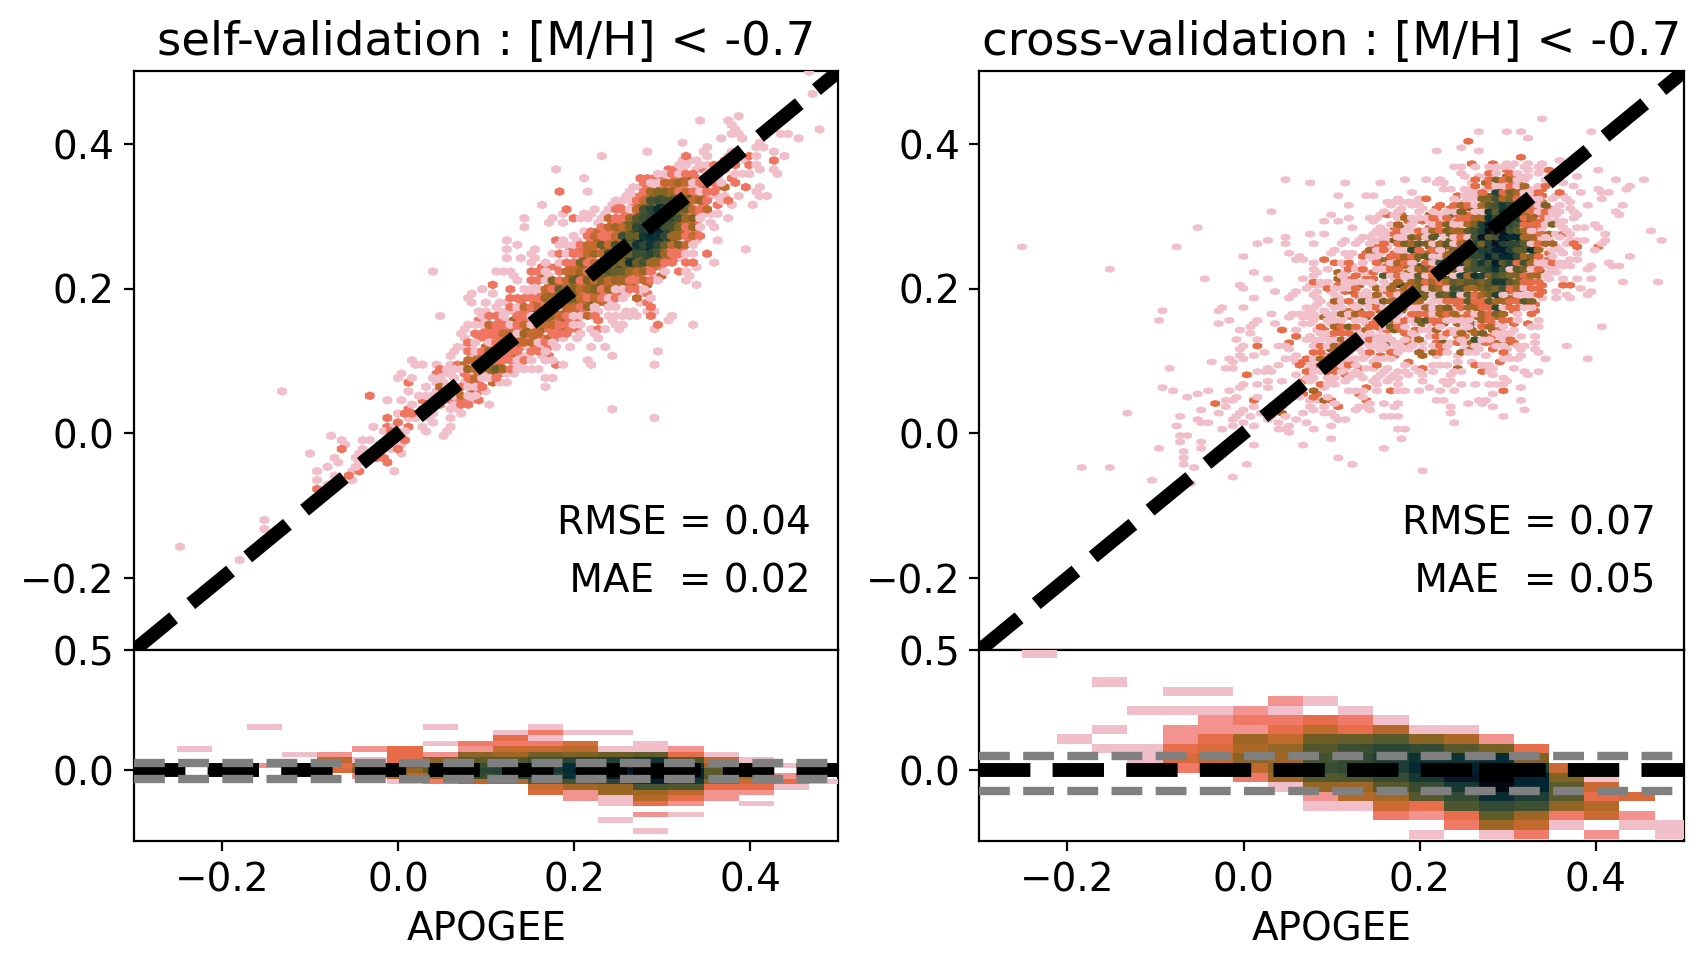

In [359]:
fig, axs = plt.subplots(1,2, figsize=(5*2, 5))
titles = ['self-validation : [M/H] < -0.7', 'cross-validation : [M/H] < -0.7']
pred_names = ['aom_self_ep300', 'aom_cross_ep300']
ax1, ax2 = axs.ravel()

ind = rdf['M_H']<-0.7
print(rdf[ind].shape)

for i in range(2):
    ax1, ax2 = draw_compare(
        axs.ravel()[i], rdf['ALPHA_M'][ind], rdf[pred_names[i]][ind],
        bins=20,
        xrange=(-0.3,0.5)
    )
    ax1.set_title(titles[i])


In [360]:
print(rmse(rdf[ind]['ALPHA_M']-np.random.normal(0.25, 0.1, len(rdf[ind]))))
print(mae(rdf[ind]['ALPHA_M'] -np.random.normal(0.25, 0.1, len(rdf[ind]))))

0.1312020937261852
0.08484774269919222


(4194, 74)


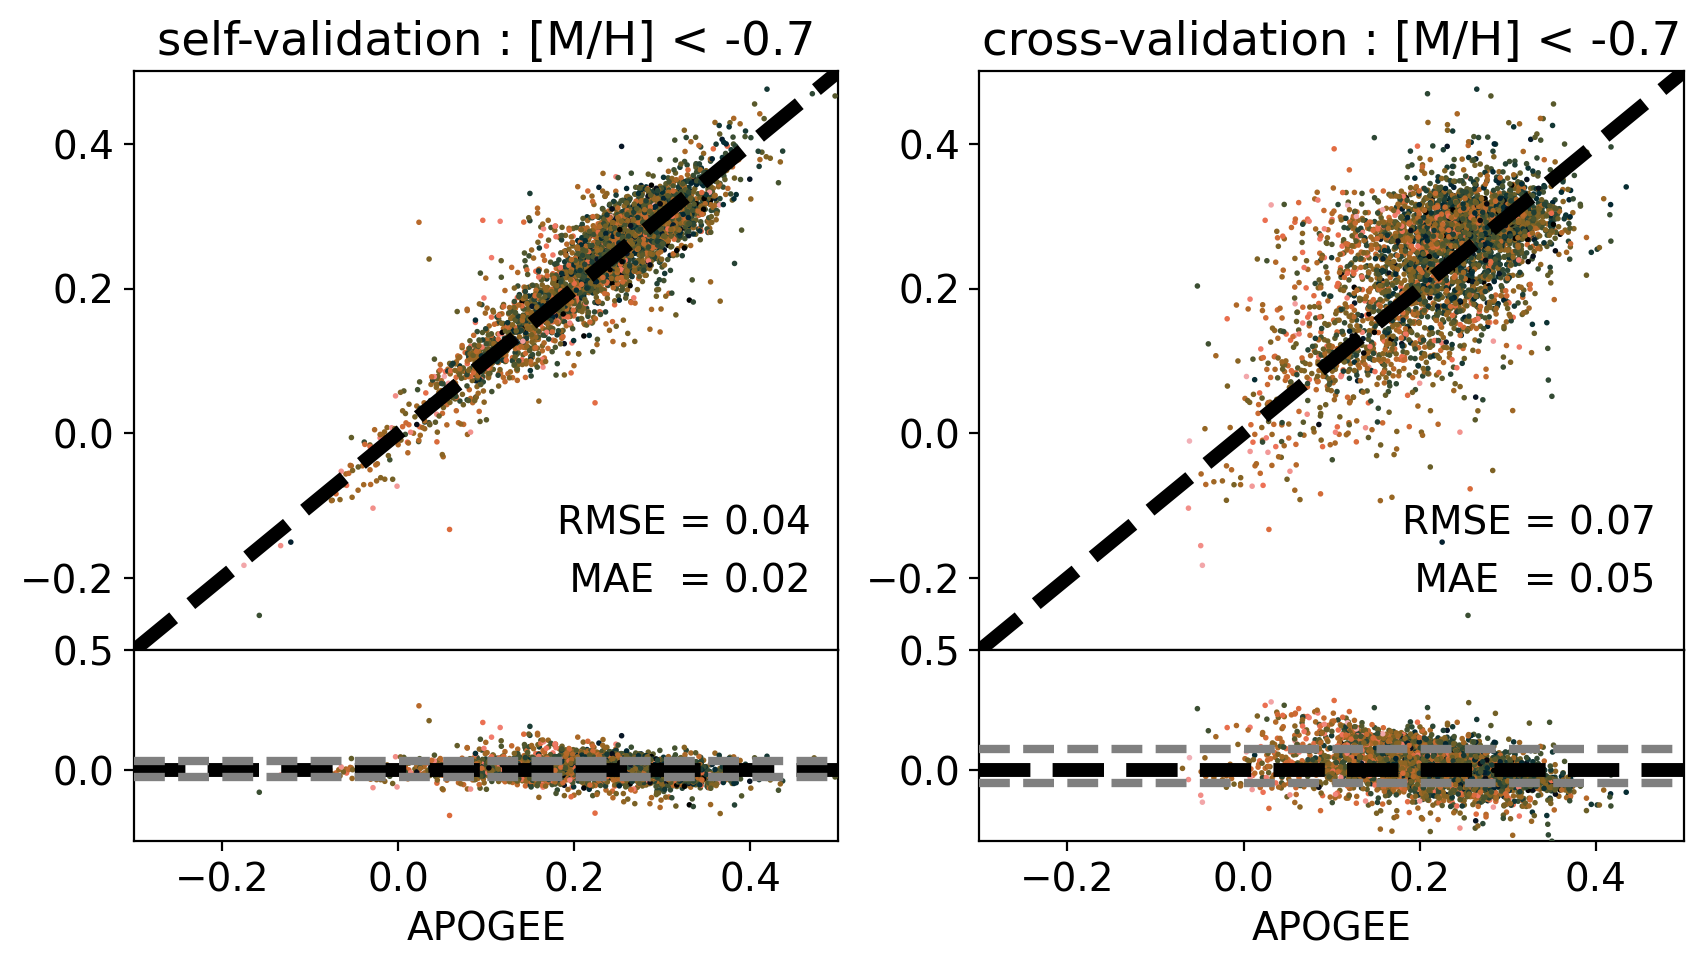

In [362]:
from transpec.docs.vis import compare_scatter

fig, axs = plt.subplots(1,2, figsize=(5*2, 5))
titles = ['self-validation : [M/H] < -0.7', 'cross-validation : [M/H] < -0.7']
pred_names = ['aom_self_ep300', 'aom_cross_ep300']
ax1, ax2 = axs.ravel()

ind = rdf['M_H']<-0.7
print(rdf[ind].shape)

for i in range(2):
    ax1, ax2, img = compare_scatter(
        axs.ravel()[i], rdf['ALPHA_M'][ind], rdf[pred_names[i]][ind],
        C=rdf['snr_rp'][ind],
        vmin=1, vmax=1500,
        xrange=(-0.3,0.5), cmap='cmr.dusk_r'
    )
    ax1.set_title(titles[i])


In [276]:
mp_df = rdf[rdf['M_H']<-0.7].copy()


snr_bp_grids = np.arange(0, 700+100, 150)
snr_rp_grids = np.linspace(0, 1000, 5)
low_snr_grids = np.linspace(0, 5, 6)

mp_df = mp_df.assign(
    snr_bp_bin  = pd.cut(mp_df['snr_bp'],   bins=snr_bp_grids),
    snr_bp10_bin= pd.cut(mp_df['snr_bp10'], bins=snr_bp_grids),
    snr_bp55_bin= pd.cut(mp_df['snr_bp55'], bins=low_snr_grids),
    snr_rp_bin  = pd.cut(mp_df['snr_rp'],   bins=snr_rp_grids),
    snr_rp10_bin= pd.cut(mp_df['snr_rp10'], bins=snr_rp_grids),
    snr_rp55_bin= pd.cut(mp_df['snr_rp55'], bins=low_snr_grids),
)

snr_bp_mids = snr_bp_grids[:-1] + np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1] + np.diff(snr_rp_grids)*0.5
low_snr_mids= low_snr_grids[:-1]+ np.diff(low_snr_grids)*0.5

pred_names = "aom_cross_ep500"
true_names = "ALPHA_M"
n_boots = 10

# rmse_bp = np.zeros([n_boots, len(snr_bp_grids)-1])
# rmse_rp = np.zeros([n_boots, len(snr_rp_grids)-1])
rmse_arr = np.zeros([6, n_boots, len(snr_bp_mids)])


bin_names = ["snr_bp_bin", "snr_bp10_bin", "snr_bp55_bin", 
            "snr_rp_bin", "snr_rp10_bin", "snr_rp55_bin"]


for j, bin_name in enumerate(bin_names):
    print("bin %s stats."%bin_name)
    for i, (gn, group) in enumerate(mp_df.groupby([bin_name])):
        print(len(group))
    #     rmse_arr[j,:,i] =  bootstrap(np.array((group[pred_names]-group[true_names])), n_boots, bootfunc=rmse)
        
    

bin snr_bp_bin stats.
90
741
2356
1064
125
bin snr_bp10_bin stats.
40
190
829
1714
1173
bin snr_bp55_bin stats.
30
1985
2043
283
34
bin snr_rp_bin stats.
84
547
1427
1375
bin snr_rp10_bin stats.
23
91
246
618
bin snr_rp55_bin stats.
137
2597
1204
334
75


In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1, ax2 = axs.ravel()


ax1.errorbar(
    snr_bp_mids, 
    np.mean(rmse_arr[0,:,:], axis=0), np.std(rmse_arr[0,:,:], axis=0),
     fmt='s-', capsize=3, c='royalblue', label='Global SNR'
)
ax1.errorbar(
    snr_bp_mids, 
    np.mean(rmse_arr[1,:,:], axis=0), np.std(rmse_arr[1,:,:], axis=0),
     fmt='o--', capsize=3, c='royalblue', label='SNR of first 10 coeff.'
)
ax1.errorbar(
    low_snr_mids, 
    np.mean(rmse_arr[2,:,:], axis=0), np.std(rmse_arr[2,:,:], axis=0),
     fmt='^:', capsize=3, c='royalblue', label='SNR of 11-55 coeff.'
)
ax1.set_xscale('log')

ax1.set_xlabel("SNR of BP coeff.");
ax1.set_ylabel(r"RMSE: [$\alpha$/M]");
ax1.axhline(y=rmse(rdf['ALPHA_M']), lw=3, ls='--', color='grey',
            label="RMSE of traing set")
ax2.axhline(y=rmse(rdf['ALPHA_M']), lw=3, ls='--', color='grey',
            label="RMSE of traing set")

ax2.errorbar(
    snr_rp_mids, 
    np.mean(rmse_arr[3,:,:], axis=0), np.std(rmse_arr[3,:,:], axis=0),
     fmt='s-', capsize=3, c='tomato', label='Global SNR'
)
ax2.errorbar(
    snr_rp_mids, 
    np.mean(rmse_arr[4,:,:], axis=0), np.std(rmse_arr[4,:,:], axis=0),
     fmt='o--', capsize=3, c='tomato', label='SNR of first 10 coeff.'
)
ax2.errorbar(
    low_snr_mids, 
    np.mean(rmse_arr[5,:,:], axis=0), np.std(rmse_arr[5,:,:], axis=0),
     fmt='^:', capsize=3, c='tomato', label='SNR of 11-55 coeff.'
)
ax2.set_xlabel("SNR of RP coeff.");
ax2.set_xscale('log')

# ax1.text(0.5, 0.85, 'RMSE of training set', transform=ax1.transAxes)
# ax2.text(0.5, 0.85, 'RMSE of training set', transform=ax2.transAxes)

ax1.set_ylim([0, 0.145]);
ax2.set_ylim([0, 0.145]);


ax1.set_xticks([0.1, 1, 10, 100, 1000]);
ax1.set_xticks([0.1, 1, 10, 100, 1000]);
ax1.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax1.set_xticklabels([0.1, 1, 10, 100, 1000]);

ax2.set_xticks([0.1, 1, 10, 100, 1000]);
ax2.set_xticks([0.1, 1, 10, 100, 1000]);
ax2.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax2.set_xticklabels([0.1, 1, 10, 100, 1000]);

ax1.legend(loc=3, fontsize=9, frameon=False, ncol=2);
ax2.legend(loc=3, fontsize=9, frameon=False, ncol=2);

plt.tight_layout()
# fig.savefig("../fig/rsme_alpha.png")

In [281]:
snr_rp_grids = [0, 250, 500, 750, 1000, 2000]

mp_df = mp_df.assign(snr_rp_bin=pd.cut(mp_df['snr_rp'], bins=snr_rp_grids))

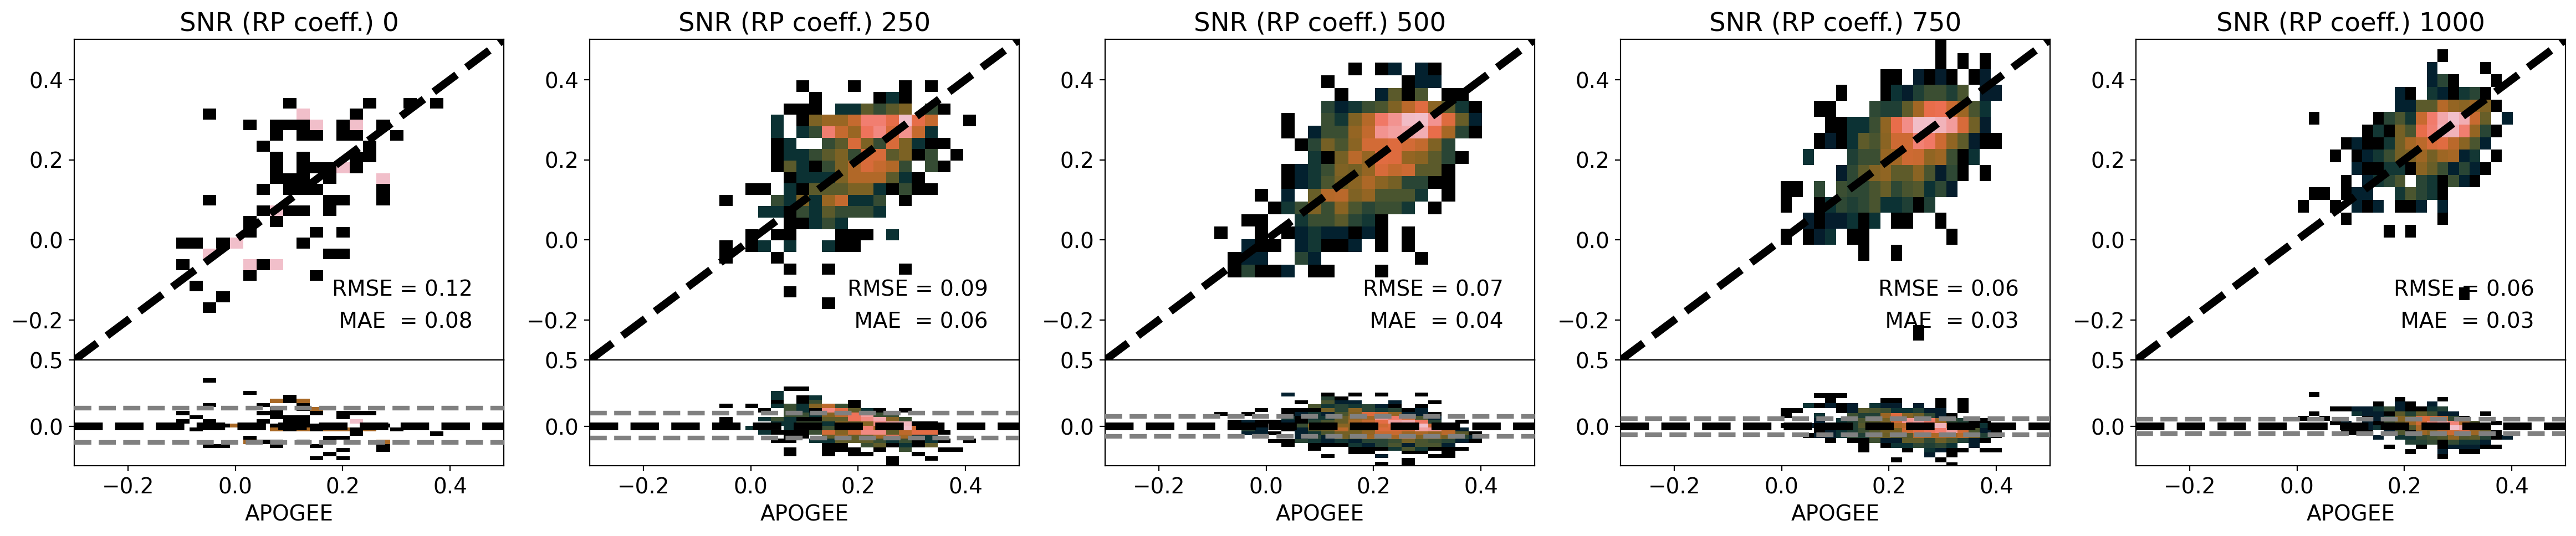

In [303]:
from transpec.docs.vis import *


titles = ["SNR (RP coeff.) {:d}".format(int(_)) for _ in snr_rp_grids]

fig, axs = plt.subplots(1, len(snr_rp_grids)-1, figsize=(5* len(snr_rp_grids)-1, 5*1))

for i, (gn,group) in enumerate(mp_df.groupby('snr_rp_bin')):

    ax1, ax2 = draw_hist2d(
        axs.ravel()[i], group['aom_cross_ep500'], group['ALPHA_M'],
        # vmin=group['snr_rp'].min(), vmax=group['snr_rp'].max(),
        xrange=(-0.3,0.5), cmap='cmr.dusk', bins=20
    )
    ax1.set_title(titles[i])